In [1]:
import librosa
import soundfile
import itertools
from aubio import source, onset
import numpy as np
import math
import random
import os
from os.path import join
import json
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
%matplotlib inline

## Librosa

In [17]:
wav_lst = os.listdir(join('NorthEastUS_Bird_testset'))
# Sampling Rate
sr = 24000
len(wav_lst)

801

In [2]:
### Function of Using LIBROSA for onset detection/counting ###
# file_path: absolute path to the sound clip
# fs: sampling rate
# mode: time-units based onset detect or env-units based onset detect; default='time'
def librosa_onsets(file_path, fs=24000, mode='time'):
    signal, fs = librosa.load(file_path, sr=fs)
    
    if mode == 'time':
        ### wait: gap between peaks; pre/post_max/avg: windowing; delta: threshold ###
        try:
            onset_ts = librosa.onset.onset_detect(signal, sr=fs, units='time', backtrack=True, 
                                                  wait=1, pre_avg=1, post_avg=1, pre_max=1, post_max=1, delta=0.2)
        except:
            return np.array([])
        #onset_ts = librosa.onset.onset_detect(signal, sr=fs, units='time', backtrack=True)
    elif mode == 'env':
        o_env = librosa.onset.onset_strength(signal, sr=fs)
        times = librosa.times_like(o_env, sr=fs)
        onset_frames = librosa.onset.onset_detect(onset_envelope=o_env, sr=fs, backtrack=True)
        onset_ts = librosa.frames_to_time(onset_frames)
        
        D = np.abs(librosa.stft(signal))
        fig, ax = plt.subplots(1, 1)
        ax.set_title('Librosa Onset Detection')
        ax.plot(times, o_env, label='Onset strength')
        ax.vlines(times[onset_frames], 0, o_env.max(), color='r', alpha=0.9,
           linestyle='--', label='Onsets')
        ax.legend()
        ax.set_xlabel('Time (s)')
    else:
        raise ValueError("Do not support this mode!")
        
    return onset_ts

In [8]:
# Load 1st .wav for instance
signal ,fs = librosa.load(join('NorthEastUS_Bird_testset', wav_lst[0]), sr=sr)

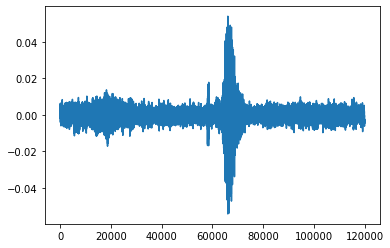

In [6]:
plt.plot(signal)
plt.show()

In [7]:
librosa_onsets(join('NorthEastUS_Bird_testset', wav_lst[0]))  # Using 'env' mode: over-sensitive

array([], dtype=float64)

In [132]:
librosa_onsets(join('ZD20K', 'outputs', wav_lst[0]), mode='time') # Default 'time', backtrack=True, After delta=0.2

array([0.32 , 0.576])

In [133]:
lib_count_lst = []

for file in os.listdir(join('ZD20K', 'outputs')):
    onset_time = librosa_onsets(join('ZD20K', 'outputs', file), mode='time')
    lib_count_lst.append((len(onset_time), onset_time.tolist()))
    if len(lib_count_lst) > 9:
        break
    
print(lib_count_lst)

[(2, [0.32, 0.576]), (1, [2.24]), (1, [0.8533333333333334]), (4, [0.256, 0.49066666666666664, 2.026666666666667, 2.8586666666666667]), (3, [0.042666666666666665, 2.0906666666666665, 2.517333333333333]), (1, [0.042666666666666665]), (1, [1.6853333333333333]), (4, [0.042666666666666665, 0.768, 0.8746666666666667, 0.9813333333333333]), (1, [0.6826666666666666]), (2, [0.042666666666666665, 3.925333333333333])]


In [63]:
assert len(lib_count_lst)==len(gt_lst)
lib_error_count = []
lib_error_onset_t = []
for idx, tup in enumerate(lib_count_lst):
    lib_error_count.append(abs(tup[0] - gt_lst[idx][0]))
    
# compute MSE of using Librosa for Crowd Counting
print(sum(lib_error_count) / len(lib_error_count))

12.2


### NorthEastUS Bird testset

In [19]:
lib_count_lst = []
anns = {}

for file in os.listdir(join('NorthEastUS_Bird_testset')):
  if file.endswith(".wav"):
    onset_time = librosa_onsets(join('NorthEastUS_Bird_testset', file), mode='time')
    lib_count_lst.append((len(onset_time), onset_time.tolist()))
    #if len(lib_count_lst) > 9:
    #    break
    
    item = {
             'fs': sr,
             'clip_length': 5.0,
             'lib_start_ts': onset_time.tolist(),
             'count_num_lib': len(onset_time),
            }
    anns[file] = item
    
print(len(anns))

800


In [20]:
ne_dir = 'NorthEastUS_Bird_testset'

with open(join('NorthEast_annotations_lib-aub-only.json'), 'w', encoding='utf-8') as f:
    json.dump(anns, f, ensure_ascii=False, indent=4)
print("Simulation Completed!")

Simulation Completed!


## Aubio

In [3]:
### Function of Using AUBIO for onset detection/counting ###
# file_path: absolute path to the sound clip
# win_div: hopping division by window size; default=4; use=2 for Counting
def get_onset_times(file_path, win_div=4):
    window_size = 1024 # FFT size
    hop_size = window_size // win_div

    sample_rate = 0
    src_func = source(file_path, sample_rate, hop_size)
    sample_rate = src_func.samplerate
    onset_func = onset('default', window_size, hop_size)
    
    duration = float(src_func.duration) / src_func.samplerate

    onset_times = [] # seconds
    while True: # read frames
        samples, num_frames_read = src_func()
        if onset_func(samples):
            onset_time = onset_func.get_last_s()
            if onset_time < duration:
                onset_times.append(onset_time)
            else:
                break
        if num_frames_read < hop_size:
            break
    
    return onset_times

In [136]:
file_path = join('ZD20K', 'outputs', wav_lst[0])
onset_times = get_onset_times(file_path)

In [143]:
count_lst = []

for file in os.listdir(join('ZD20K', 'outputs')):
    onset_time = get_onset_times(join('ZD20K', 'outputs', file), win_div=2)
    count_lst.append((len(onset_time), onset_time))
    if len(count_lst) > 9:
        break
    
print(count_lst)

[(7, [0.0, 0.2043083906173706, 0.3319047689437866, 1.1173468828201294, 1.9653061628341675, 2.059659957885742, 2.164625883102417]), (2, [1.2290703058242798, 1.7537188529968262]), (9, [0.48217687010765076, 0.6090475916862488, 1.3082993030548096, 1.517346978187561, 1.5733786821365356, 1.6295918226242065, 1.6893877983093262, 1.7456235885620117, 1.8044670820236206]), (10, [0.1531972736120224, 0.2757823169231415, 0.3731292486190796, 0.4663265347480774, 0.575986385345459, 0.7185714244842529, 0.7724036574363708, 0.8351020216941833, 1.6122221946716309, 1.7330158948898315]), (2, [0.0, 0.7468934059143066]), (1, [0.0]), (3, [0.9247392416000366, 1.2026077508926392, 1.2604762315750122]), (7, [0.15768706798553467, 0.2146485298871994, 0.26573696732521057, 0.3880952298641205, 1.1408843994140625, 1.2304534912109375, 1.338344693183899]), (6, [0.0, 0.41814059019088745, 0.9612471461296082, 1.346258521080017, 1.4593197107315063, 1.5599772930145264]), (1, [0.0])]


### NorthEast Bird testset

In [24]:
aub_count_lst = []
aub_anns = {}

assert os.path.exists(join('NorthEast_annotations_lib-aub-only.json'))

for file in os.listdir(join('NorthEastUS_Bird_testset')):
  if file.endswith('.wav'):
    onset_time = get_onset_times(join('NorthEastUS_Bird_testset', file), win_div=2)
    aub_count_lst.append((len(onset_time), onset_time))
    #if len(lib_count_lst) > 9:
    #    break
    
    anns[file]['aub_start_ts'] = onset_time
    item_name = 'count_num_aub'
    anns[file][item_name] = len(onset_time)
    
print(len(anns))

800


In [27]:
# Overwrite
with open(join('NorthEast_annotations_lib-aub-only.json'), 'w', encoding='utf-8') as f:
    json.dump(anns, f, ensure_ascii=False, indent=4)

### Ground-truth

In [ ]:
with open('annotations.json') as f:
    anns = json.load(f)

In [21]:
gt_lst = []

for file in os.listdir('outputs'):
    key_name = file.split('.')[0]
    
    start_ts = [item['start_t'] for item in anns[key_name]['birds']]
    
    gt_lst.append((anns[key_name]['count'], sorted(start_ts)))
    
print(gt_lst)

[(10, [0.015876305004615496, 0.04055874747533283, 0.8560014930756557, 1.113190095751739, 1.4673785172424894, 1.8090983152621483, 1.9343189066546818, 2.1345905017997007, 4.339293069060367, 5.427446743592197]), (10, [0.37726755844016974, 0.39026541015092964, 0.865730286394628, 1.289283348606935, 1.3144453738689539, 2.045300700875337, 4.526546265432463, 4.606212095954632, 4.9642929183415685, 5.358079898350199]), (10, [2.0422582831429015, 2.4019279826428646, 3.684572612475001, 4.631383724230315, 5.174263512148089, 5.808403381671271, 7.213222444554427, 7.247640891734407, 8.61479029189398, 9.305477105584105]), (10, [0.08957469750368154, 0.7055040435527499, 0.7437540168754013, 1.1322561652724625, 1.1368965504921866, 2.508784130854608, 2.9445331997541864, 3.1993645288836, 3.36240098300053, 4.24348693561246]), (10, [0.7902820896082009, 0.8351156931336404, 0.9657154572200708, 2.8727539475059127, 4.742736772641742, 4.8263467105994025, 6.537025166068086, 7.504311641580494, 7.643364108606821, 7.805

In [22]:
assert len(count_lst)==len(gt_lst)
error_count = []
error_onset_t = []
for idx, tup in enumerate(count_lst):
    error_count.append(abs(tup[0] - gt_lst[idx][0]))
    
# compute MSE of using Aubio for Crowd Counting
print(sum(error_count) / len(error_count))

3.6


# TUT-SED Synthetic 2016

In [19]:
# path to annotation directory (meta dir)
path_to_meta = "/home/zdai/repos/TUT-SED_Synthetic_2016/TUT-SED-synthetic-2016.meta/TUT-SED-synthetic-2016/meta"

TUT = {}
max_event_t = 0.0

# Load TUT2016 dataset annotations into TUT: a dictionary of sound event classes, start_t, end_t
for filename in os.listdir(path_to_meta):
    with open(join(path_to_meta, filename), 'r') as f:
        lines = f.readlines()
    #print(lines)
    
    sound_srcs = []
    for item in lines:
        t1 = float(item.split('\t')[0])
        t2 = float(item.split('\t')[1])
        if t2 > max_event_t:
            max_event_t = t2
        cls = item.split('\t')[2][:-1]
        
        sound_srcs.append({"cls": cls,
                          "start_t": t1,
                          "end_t": t2})
    tut = {"clip_t": max_event_t,
          "events": sound_srcs}
    TUT[filename] = tut

print("Number of original TUT-SED Synthetic 2016 samples = ", len(TUT))

100


In [ ]:
### Compute the Polyphonic Level/Ratio/Density of original TUT clip ###
def polyphony(clip):
    step = 0.01

    t = np.arange(0, clip['clip_t'], step)
    t_tp = np.zeros(t.shape)
    t_den = np.zeros(t.shape)
    t_area = np.zeros(t.shape)

    max_track = 0

    for idx, x in np.ndenumerate(t):
        mono_track = 0
        for instance in clip['events']:
            if x >= instance['start_t'] and x <= instance['end_t']:
                mono_track += 1

        if mono_track >= 2:
            t_tp[idx] = step
            t_den[idx] = math.e**mono_track * step
            t_area[idx] = mono_track * step

        max_track = mono_track if mono_track > max_track else max_track

    polyphonic_ratio = np.sum(t_tp) / clip['clip_t']
    polyphonic_density = np.sum(t_den) / clip['clip_t']
    # Specify Max number of "wall": donno know height of wall here
    #polyphonic_area = np.sum(t_area) / (clip['clip_t'] * 5)

    PL = max_track
    PR = polyphonic_ratio
    PD = polyphonic_density
    return PL, PR, PD

In [151]:
TUT_stats = []
max_PL = 0

for idx, (key, val) in enumerate(TUT.items()):
    pl, pr, pd = polyphony(val)
    TUT_stats.append((pl, pr, pd))
    if pl > max_PL:
        max_PL = pl
    #break
    
print("Max Polyphony Level Ever in TUT-SED Synthetic 2016 = ", max_PL)

Max Polyphony Level Ever in TUT-SED Synthetic 2016 =  6


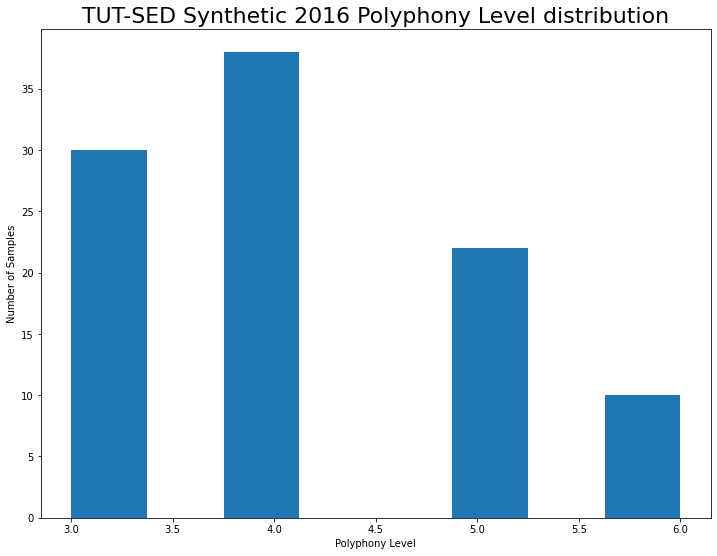

In [152]:
fig3, ax3 = plt.subplots(figsize=(12,9))
ax3.hist([int(item[0]) for item in TUT_stats], bins='auto', rwidth=0.99)
ax3.set_xlabel("Polyphony Level")
ax3.set_ylabel("Number of Samples")
ax3.set_title("TUT-SED Synthetic 2016 Polyphony Level distribution", fontsize=22)

fig3.savefig('TUT2016_hist.png')
plt.show()

## Dataset Transformation
### Chop Recordings into 5s clips

In [133]:
# Specify path to audio files dirs
path_to_dir = "/home/zdai/repos/TUT-SED_Synthetic_2016"
dir1 = join(path_to_dir, 'TUT-SED-synthetic-2016.audio.1', 'TUT-SED-synthetic-2016', 'audio')
dir2 = join(path_to_dir, 'TUT-SED-synthetic-2016.audio.2', 'TUT-SED-synthetic-2016', 'audio')
dir3 = join(path_to_dir, 'TUT-SED-synthetic-2016.audio.3', 'TUT-SED-synthetic-2016', 'audio')
dir4 = join(path_to_dir, 'TUT-SED-synthetic-2016.audio.4', 'TUT-SED-synthetic-2016', 'audio')
dir5 = join(path_to_dir, 'TUT-SED-synthetic-2016.audio.5', 'TUT-SED-synthetic-2016', 'audio')

# Sampling rate
sr = 24000

# Uniform clip length (s)
clip_t = 5

In [ ]:
### Create single annotation for each (5)s clip ###
# tut: dictionary of original annotation [make sure to extract Ground-truth annotation
#      including 'class', 'start_t', 'end_t' from original dataset, e.g., <TUT> in last section]
# start_t: Start timestamp in the original clip
# end_t: Ending timestamp in the original clip
# sr: sampling rate
def create_wav_ann(tut, start_t, end_t, sr):
    # Atomic temporal step of integral to compute PL, PR, PD etc.
    # The small the better resolution, but costs more tiem to compute
    step = 0.01

    t = np.arange(start_t, end_t, step)
    t_tp = np.zeros(t.shape)
    t_den = np.zeros(t.shape)
    t_area = np.zeros(t.shape)
    
    max_track = 0
    sound_srcs = []
    
    # Determine sound instances that occur in the sub-clip
    for instance in tut['events']:
        if start_t < instance['end_t'] and end_t > instance['start_t']:
            t1 = instance['start_t'] if instance['start_t']>start_t else start_t
            t2 = instance['end_t'] if instance['end_t']<end_t else end_t
            
            end_time = t2 % (end_t - start_t) if t2 % (end_t - start_t) != 0 else end_t - start_t
            
            sound_srcs.append({"BirdName": instance['cls'],
                                      "start_t": t1 % (end_t - start_t),
                                      "end_t": end_time})
    
    # Compute PL, PR, PA, PD
    for idx, x in np.ndenumerate(t):
        mono_track = 0
        for instance in tut['events']:
            if x > instance['start_t'] and x < instance['end_t']:
                mono_track += 1
                
        if mono_track >= 2:
            t_tp[idx] = step
            t_den[idx] = math.e**mono_track * step
            t_area[idx] = mono_track * step

        max_track = mono_track if mono_track > max_track else max_track

    polyphonic_ratio = np.sum(t_tp) / (end_t - start_t)
    polyphonic_density = np.sum(t_den) / (end_t - start_t)
    # Specify Max number of "wall": donno know height of wall here
    polyphonic_area = np.sum(t_area) / (end_t - start_t)

    PL = max_track
    PR = polyphonic_ratio
    PD = polyphonic_density
    PA = polyphonic_area
    
    # Annotation for the Sub-clip
    item = {
             'fs': sr,
             'clip_length': end_t - start_t,
             'birds': sound_srcs,
             'count': len(sound_srcs),
             'PolyphonicRatio': PR,
             'PolyphonicDensity': PD,
             'PolyphonyLevel': PL,
             'PolyphonicArea': PA,
            }
    
    return item

In [150]:
# Outputs dir
tut_dir = 'TUT2016'
os.makedirs(join(tut_dir, 'outputs')) if not os.path.exists(join(tut_dir, 'outputs')) else None

# Dictionary of all Annotations
annotations = {}

for dir0 in [dir1, dir2, dir3, dir4, dir5]:
    for file in os.listdir(dir0):
        signal, fs = librosa.load(join(dir0, file), sr=sr)

        fileidx = file.split('.')[0].split('-')[-1]
        wavname = 'TUT-SED-synthetic-2016-mix-' + fileidx
        annname = 'TUT-SED-synthetic-2016-annot-' + fileidx

        num_clips = len(signal) // (clip_t * sr)

        for index in range(num_clips):

            filename = "mix-{}_index-{}".format(int(fileidx), index)

            # Create .wav
            soundfile.write(file=join(tut_dir, 'outputs', filename+'.wav'), 
                            data=signal[index * clip_t * sr:(index+1) * clip_t * sr], 
                            samplerate=sr)

            # Add annotation
            ann = create_wav_ann(TUT[annname+'.txt'], index * clip_t, (index+1) * clip_t, sr)

            annotations[filename] = ann

            #if index >=10:
            #    break
        #break

            
if os.path.exists(join(tut_dir, 'TUTannotations.json')):
    with open(join(tut_dir, 'TUTannotations.json')) as f:
        new_anns = json.load(f)

    new_anns.update(annotations)
    with open(join(tut_dir, 'TUTannotations.json'), 'w', encoding='utf-8') as f:
        json.dump(new_anns, f, ensure_ascii=False, indent=4)
else:
    with open(join(tut_dir, 'TUTannotations.json'), 'w', encoding='utf-8') as f:
        json.dump(annotations, f, ensure_ascii=False, indent=4)
print("Simulation Completed!")

Simulation Completed!


# Evaluation

## (1) Pre-process Rooster

In [258]:
# Load Rooster-only annotation
anns = {}
with open(join('annotations_pred_1_5_rooster.json')) as f:
    anns = json.load(f)
print(len(anns_ro1_5))

with open(join('annotations_pred_6_10_rooster.json')) as f:
    anns_ro6_10 = json.load(f)
print(len(anns_ro6_10))

anns.update(anns_ro6_10)
print(len(anns))

80000
80000
80000


In [261]:
# Load CRNNNet & dnd-SED
with open(join('final_result_rooster', 'annotations_rooster_pred_6_10_SoundCount_10times.json')) as f:
    anns_best = json.load(f)
print(len(anns_best))

with open(join('final_result_rooster', 'annotations_rooster_pred_6_10_epoch60_OS.json')) as f:
    anns_os = json.load(f)
print(len(anns_os))

anns_merge = anns_os.copy()

with open(join('final_result_rooster', 'annotations_rooster_pred_6_10_epoch60_RC.json')) as f:
    anns_rc = json.load(f)
print(len(anns_dndsed))

with open(join('final_result_rooster', 'annotations_rooster_pred_6_10_CRNNNet_10times.json')) as f:
    anns_crnnnet = json.load(f)
print(len(anns_crnnnet))

with open(join('final_result_rooster', 'annotations_rooster_pred_6_10_dndSED_10times.json')) as f:
    anns_dndsed = json.load(f)
print(len(anns_dndsed))

with open(join('final_result_rooster', 'annotations_rooster_pred_6_10_SELDNet_10times.json')) as f:
    anns_seldnet = json.load(f)
print(len(anns_seldnet))


# Update keyname for benchmarks
for idx, (key, val) in enumerate(anns_merge.items()):
  if idx < len(anns_merge):
    anns_merge[key]['count_num_best'] = anns_best[key]['count_num_pred']
    #anns_merge[key]['count_num_merge'] = anns_merge[key]['count_num_pred']
    anns_merge[key]['count_num_os'] = anns_os[key]['count_num_pred']
    anns_merge[key]['count_num_rc'] = anns_rc[key]['count_num_pred']
    anns_merge[key]['count_num_crnnnet'] = anns_crnnnet[key]['count_num_pred']
    anns_merge[key]['count_num_dndsed'] = anns_dndsed[key]['count_num_pred']
    anns_merge[key]['count_num_seldnet'] = anns_seldnet[key]['count_num_pred']
    del anns_merge[key]['count_num_pred']
    
anns_merge_os = anns_merge.copy()

print("Eventual test samples = ", len(anns_merge_os))

4004
3999
4004
4004
4004
4004
Eventual test samples =  3999


In [262]:
# Directly analysis test split (count6_10)
anns = anns_merge_os
len(anns)

3999

In [263]:
num_of_onset_samples, num_1_5_samples = 0, 0

# Use Librosa(lib) / Aubio(aub) to count test .wavs in "ZD20K_count1-10" dataset
for index, (filename, item) in enumerate(anns.items()):
    if index >= 40000:
        break
    #if index % 2 == 0:
    #    continue
    
    if 1: #item['count_num_pred'] is not None:
        if os.path.isfile(join('RO80K_count1-20', 'outputs', filename + '.wav')):
            path_to_file = join('RO80K_count1-20', 'outputs', filename + '.wav')
        else:
            raise ValueError(filename + '.wav', " does not exist!")
            
        onset_time = librosa_onsets(path_to_file, mode='time')
        librosa_count = len(onset_time)
        anns[filename]['count_num_lib'] = librosa_count
        
        onset_times_aub = get_onset_times(path_to_file, win_div=2)
        aub_count = len(onset_times_aub)
        anns[filename]['count_num_aub'] = aub_count
        
        key_best = 'count_num_best'
        key_merge = 'count_num_merge'
        key_os = 'count_num_os'
        key_rc = 'count_num_rc'
        key_cr = 'count_num_crnnnet'
        key_dn = 'count_num_dndsed'
        key_se = 'count_num_seldnet'
        if filename in anns_merge_os:
            ### Insert Merge & OS benchmark ###
            anns[filename][key_best] = anns_merge_os[filename][key_best]
            #anns[filename][key_merge] = anns_merge_os[filename][key_merge]
            anns[filename][key_os] = anns_merge_os[filename][key_os]
            anns[filename][key_rc] = anns_merge_os[filename][key_rc]
            anns[filename][key_cr] = anns_merge_os[filename][key_cr]
            anns[filename][key_dn] = anns_merge_os[filename][key_dn]
            anns[filename][key_se] = anns_merge_os[filename][key_se]
        else:
            # Fill with GT
            anns[filename][key_best] = anns[filename]['count_num_pred']
            #anns[filename][key_merge] = anns[filename]['count_num_pred']
            anns[filename][key_os] = anns[filename]['count_num_pred']
            anns[filename][key_rc] = anns[filename]['count_num_pred']
            anns[filename][key_cr] = anns[filename]['count_num_pred']
            anns[filename][key_dn] = anns[filename]['count_num_pred']
            anns[filename][key_se] = anns[filename]['count_num_pred']
            num_1_5_samples += 1
        
        num_of_onset_samples += 1
        
print("Detected total samples = ", num_of_onset_samples)
print("%d samples has count<=5" % num_1_5_samples)

Detected total samples =  3999
0 samples has count<=5


In [ ]:
# Save??


## (2) Pre-process 4birds

In [278]:
anns = {}
# Load annotations
with open(join('annotations_pred_1_10_epoch50_v2.json')) as f:
    anns = json.load(f)

print(len(anns))

7998


In [309]:
### Use this base! ###
anns = {}
# Load count 1-10 fully
with open(join('annotations_pred_1_10_epoch50_v2.json')) as f:
    anns = json.load(f)
print(len(anns))

# Update 6-10 part
with open(join('annotations_pred_6_10_epoch60_v1.json')) as f:
    anns6_10 = json.load(f)
    
anns.update(anns6_10)
print(len(anns))

7998
7998


In [310]:
# Load CRNNNet & dnd-SED
with open(join('final_result_4birds', 'annotations_4birds_pred_6_10_SoundCount_10times.json')) as f:
    anns_best = json.load(f)
print(len(anns_best))

with open(join('final_result_4birds', 'annotations_4birds_pred_6_10_CRNNNet_10times.json')) as f:
    anns_crnnnet = json.load(f)
print(len(anns_crnnnet))

with open(join('final_result_4birds', 'annotations_4birds_pred_6_10_dndSED_10times.json')) as f:
    anns_dndsed = json.load(f)
print(len(anns_dndsed))

with open(join('final_result_4birds', 'annotations_4birds_pred_6_10_SELDNet_10times.json')) as f:
    anns_seldnet = json.load(f)
print(len(anns_seldnet))

4004
4004
4004
4004


In [311]:
# Load Merge & OS
with open(join('final_result_4birds', 'annotations_pred_6_10_epoch60_merge.json')) as f:
    anns_merge = json.load(f)
print(len(anns_merge))

with open(join('final_result_4birds', 'annotations_pred_6_10_epoch60_OS.json')) as f:
    anns_os = json.load(f)
print(len(anns_os))

with open(join('final_result_4birds', 'annotations_pred_6_10_epoch60_RC.json')) as f:
    anns_rc = json.load(f)
print(len(anns_rc))

3999
3999
3999


In [312]:
# Update keyname for benchmarks
for idx, (key, val) in enumerate(anns_merge.items()):
  if idx < len(anns_merge):
    anns_merge[key]['count_num_best'] = anns_best[key]['count_num_pred']
    anns_merge[key]['count_num_merge'] = anns_merge[key]['count_num_pred']
    anns_merge[key]['count_num_os'] = anns_os[key]['count_num_pred']
    anns_merge[key]['count_num_rc'] = anns_rc[key]['count_num_pred']
    anns_merge[key]['count_num_crnnnet'] = anns_crnnnet[key]['count_num_pred']
    anns_merge[key]['count_num_dndsed'] = anns_dndsed[key]['count_num_pred']
    anns_merge[key]['count_num_seldnet'] = anns_seldnet[key]['count_num_pred']
    del anns_merge[key]['count_num_pred']
    
anns_merge_os = anns_merge.copy()

print(len(anns_merge_os))

3999


In [313]:
num_of_onset_samples, num_1_5_samples = 0, 0

# Use Librosa(lib) / Aubio(aub) to count test .wavs in "ZD20K_count1-10" dataset
for index, (filename, item) in enumerate(anns.items()):
    if item['count_num_pred'] is not None:
        if os.path.isfile(join('ZD20K', 'outputs', filename + '.wav')):
            path_to_file = join('ZD20K', 'outputs', filename + '.wav')
        elif os.path.isfile(join('ZD20K_count6-10', 'outputs', filename + '.wav')):
            path_to_file = join('ZD20K_count6-10', 'outputs', filename + '.wav')
        else:
            raise ValueError(filename + '.wav', " does not exist!")
            
        onset_time = librosa_onsets(path_to_file, mode='time')
        librosa_count = len(onset_time)
        anns[filename]['count_num_lib'] = librosa_count
        
        onset_times_aub = get_onset_times(path_to_file, win_div=2)
        aub_count = len(onset_times_aub)
        anns[filename]['count_num_aub'] = aub_count
        
        key_best = 'count_num_best'
        key_merge = 'count_num_merge'
        key_os = 'count_num_os'
        key_rc = 'count_num_rc'
        key_cr = 'count_num_crnnnet'
        key_dn = 'count_num_dndsed'
        key_se = 'count_num_seldnet'
        if filename in anns_merge_os:
            ### Insert Merge & OS benchmark ###
            anns[filename][key_best] = anns_merge_os[filename][key_best]
            anns[filename][key_merge] = anns_merge_os[filename][key_merge]
            anns[filename][key_os] = anns_merge_os[filename][key_os]
            anns[filename][key_rc] = anns_merge_os[filename][key_rc]
            anns[filename][key_cr] = anns_merge_os[filename][key_cr]
            anns[filename][key_dn] = anns_merge_os[filename][key_dn]
            anns[filename][key_se] = anns_merge_os[filename][key_se]
        else:
            # Fill with GT
            anns[filename][key_best] = anns[filename]['count_num_pred']
            anns[filename][key_merge] = anns[filename]['count_num_pred']
            anns[filename][key_os] = anns[filename]['count_num_pred']
            anns[filename][key_rc] = anns[filename]['count_num_pred']
            anns[filename][key_cr] = anns[filename]['count_num_pred']
            anns[filename][key_dn] = anns[filename]['count_num_pred']
            anns[filename][key_se] = anns[filename]['count_num_pred']
            num_1_5_samples += 1
        
        num_of_onset_samples += 1
        
print("Detected total samples = ", num_of_onset_samples)
print("%d samples has count<=5" % num_1_5_samples)

Detected total samples =  7998
3999 samples has count<=5


In [314]:
# Save updated anns with grount-truth lib & aub
with open('annotations_4bird-best_pred_6_10_epoch60-ALL.json', 'w', encoding='utf-8') as f:
    json.dump(anns, f, ensure_ascii=False, indent=4)

In [5]:
# Load updated anns with grount-truth lib & aub
with open('annotations_4bird-best_pred_6_10_epoch60-ALL.json', 'r', encoding='utf-8') as f:
    anns = json.load(f)
print(len(anns))

7998


## Hyperparam: Count's correlation to P.L. P.R. P.A. P.D.

### (Yuhang: skip this part)

In [3]:
sort_attr = 'PolyphonyLevel'
PR_lst = sorted(anns.items(), key=lambda x: x[1][sort_attr], reverse=True)

In [4]:
len(PR_lst)

40000

In [5]:
count_lst, pl_lst, pa_lst, pr_lst, pd_lst = [], [], [], [], []

for item in PR_lst:
    pl_lst.append(item[1]['PolyphonyLevel'])
    pa_lst.append(item[1]['PolyphonicArea'])
    pr_lst.append(item[1]['PolyphonicRatio'])
    pd_lst.append(item[1]['PolyphonicDensity'])
    count_lst.append(item[1]['count'])

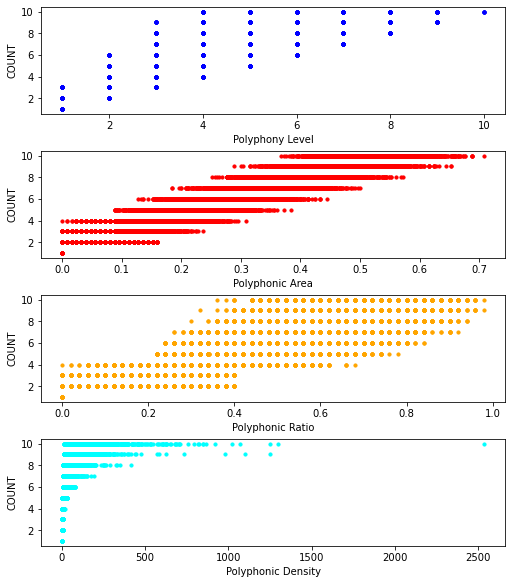

In [6]:
fig, ax = plt.subplots(4, 1, figsize=(7, 8), constrained_layout=True)

ax[0].scatter(pl_lst, count_lst, color='b', s=10)
ax[0].set_xlabel("Polyphony Level")
ax[0].set_ylabel("COUNT")

ax[1].scatter(pa_lst, count_lst, color='r', s=10)
ax[1].set_xlabel("Polyphonic Area")
ax[1].set_ylabel("COUNT")

ax[2].scatter(pr_lst, count_lst, color='orange', s=10)
ax[2].set_xlabel("Polyphonic Ratio")
ax[2].set_ylabel("COUNT")

ax[3].scatter(pd_lst, count_lst, color='cyan', s=10)
ax[3].set_xlabel("Polyphonic Density")
ax[3].set_ylabel("COUNT")

#fig.savefig('ZD20K_distribution', facecolor='white', transparent=False)
plt.show()

/home/zdai/anaconda3/envs/DLpy37/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


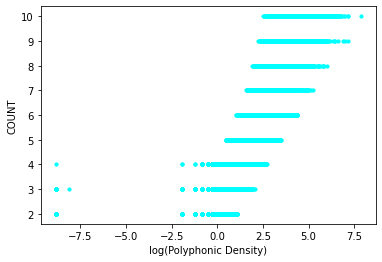

In [7]:
fig2, ax2 = plt.subplots()

ax2.scatter(np.log(pd_lst), count_lst, color='cyan', s=10)
ax2.set_xlabel("log(Polyphonic Density)")
ax2.set_ylabel("COUNT")

#fig2.savefig('ZD20K_log-polyphonicDensity', facecolor='white', transparent=False)
plt.show()

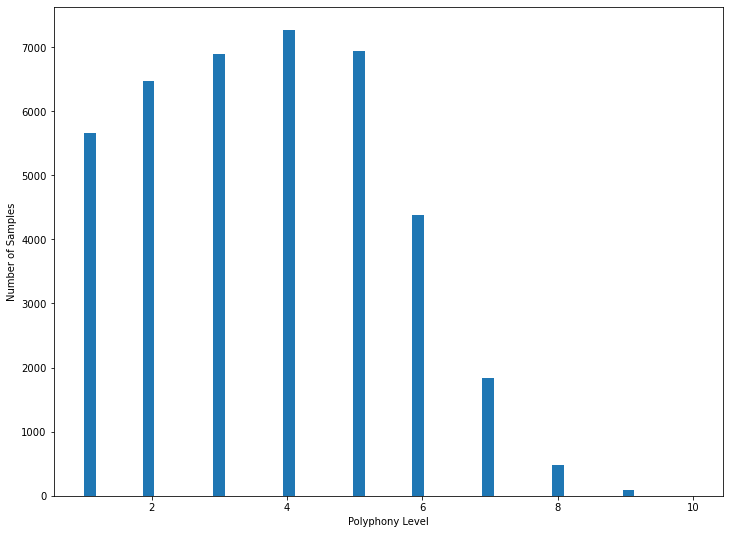

In [11]:
fig3, ax3 = plt.subplots(figsize=(12,9))
ax3.hist(pl_lst, bins='auto', rwidth=0.99)
ax3.set_xlabel("Polyphony Level")
ax3.set_ylabel("Number of Samples")

#fig3.savefig('ZD20K_hist')
plt.show()

## Polyphony Level

#### (Load annotation for Histogram Distribution analysis)

In [111]:
# Load Four-bird annotations
with open(join('annotations_pred.json')) as f:
    anns = json.load(f)

with open(join('annotations_pred_6_10.json')) as f:
    anns6_10 = json.load(f)

anns.update(anns6_10)
print(len(anns))

40000


In [173]:
# Load Rooster-only annotation
with open(join('annotations_pred_6_10_rooster.json')) as f:
#with open(join('annotations_rooster_pred_6_10_epoch60.json')) as f:
    anns = json.load(f)
    
with open(join('annotations_pred_1_5_rooster.json')) as f:
    anns1_5 = json.load(f)

anns1_5_firsthalf = dict(itertools.islice(anns1_5.items(), 20000))

anns.update(anns1_5_firsthalf)
print(len(anns))

80000


In [103]:
# Load Rooster-only annotation of "count<=10" items
with open(join('annotations_pred_6_10_rooster.json')) as f:
#with open(join('annotations_rooster_pred_6_10_epoch60.json')) as f:
    anns1_5 = json.load(f)

anns = dict(itertools.islice(anns1_5.items(), 40000))
print(len(anns))

40000


In [103]:
# Load Complete annotations
with open(join('annotations_pred_1_10_epoch50_v2_4birds-lib-aub.json')) as f:
    anns = json.load(f)
print(len(anns))

7998


#### (end loading)

In [6]:
# Number of min samples in a bin to be consider for histogram analysis
hist_thres = 10

In [322]:
### Sort annotations in order of an attribute ###
# ann: annotations dictionary
# sort_attr: Sort by order of an attribute
def eval_polyphony(ann, sort_attr = 'PolyphonyLevel'):
    
    PR_lst = sorted(ann.items(), key=lambda x: x[1][sort_attr], reverse=False)
    
    attr_lst = []
    count_num_pred_lst, count_lst = [], []
    snr_lst = []
    lib_lst, aub_lst = [], []
    best_lst, merge_lst, os_lst, rc_lst, cr_lst, dn_lst, se_lst = [], [], [], [], [], [], []

    for item in PR_lst:
        if 1: #item[1]['count_num_pred'] is not None:
            # Rescale Area-polyp
            if sort_attr == 'PolyphonicArea':
                attr_lst.append(item[1][sort_attr] * 5)
            else:
                attr_lst.append(item[1][sort_attr])    
            count_lst.append(item[1]['count'])
            count_num_pred_lst.append(item[1]['count_num_pred']) # Comment in/out
            snr_lst.append(item[1]['snr'])
            
            lib_lst.append(item[1]['count_num_lib'])
            aub_lst.append(item[1]['count_num_aub'])
            
            best_lst.append(item[1]['count_num_best'])
            merge_lst.append(item[1]['count_num_merge'])  # Comment in/out
            os_lst.append(item[1]['count_num_os'])
            rc_lst.append(item[1]['count_num_rc'])
            cr_lst.append(item[1]['count_num_crnnnet'])
            dn_lst.append(item[1]['count_num_dndsed'])
            se_lst.append(item[1]['count_num_seldnet'])
            
    print("Number of test samples = ", len(attr_lst))
    results = [attr_lst, count_lst, count_num_pred_lst, snr_lst, lib_lst, aub_lst,
               merge_lst, os_lst, rc_lst, cr_lst, dn_lst, se_lst, best_lst]
    
    return results

In [323]:
sorted_result = eval_polyphony(anns, sort_attr = 'PolyphonyLevel')
X, Y_gt, Y_pred, SNR, Y_lib, Y_aub, Y_merge, Y_os, Y_rc = sorted_result[0], sorted_result[1], sorted_result[2], sorted_result[3], sorted_result[4], sorted_result[5], sorted_result[6], sorted_result[7], sorted_result[8]
Y_cr, Y_dn, Y_se, Y_best = sorted_result[9], sorted_result[10], sorted_result[11], sorted_result[12]

Number of test samples =  7998


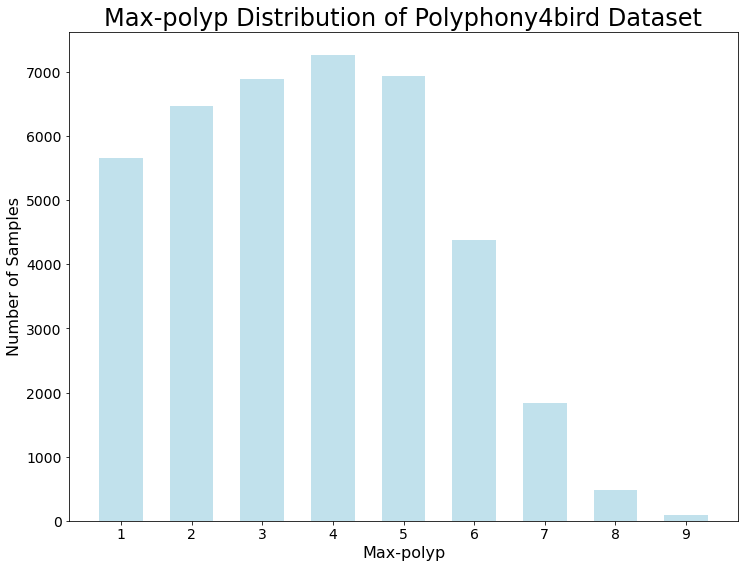

In [114]:
# Polyphony4bird hist
fig3, ax3 = plt.subplots(figsize=(12,9))
ax3.hist(X, bins=np.arange(1, 11) - 0.5, rwidth=0.618, color='lightblue', alpha=0.75)
ax3.set_title("Max-polyp Distribution of Polyphony4bird Dataset", fontsize=24)
ax3.set_xlabel("Max-polyp", fontsize=16)
ax3.set_ylabel("Number of Samples", fontsize=16)
ax3.tick_params(axis="x", labelsize=14)
ax3.tick_params(axis="y", labelsize=14)
plt.xticks(range(1, 10))

fig3.savefig(join('images', 'MergeOS_4bird', 'count1-10_hist'))
plt.show()

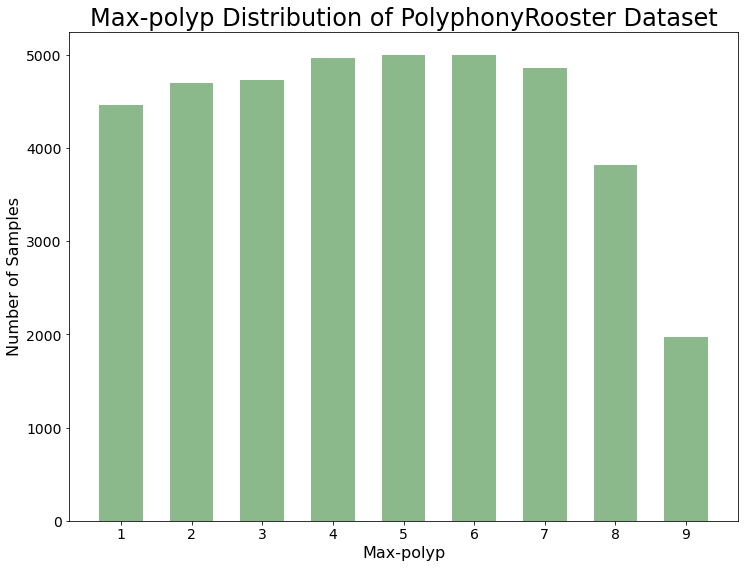

In [110]:
# PolyphonyRooster hist
fig3, ax3 = plt.subplots(figsize=(12,9))
ax3.hist(X, bins=np.arange(1, 11) - 0.5, rwidth=0.618, color='darkgreen', alpha=0.45)
ax3.set_title("Max-polyp Distribution of PolyphonyRooster Dataset", fontsize=24)
ax3.set_xlabel("Max-polyp", fontsize=16)
ax3.set_ylabel("Number of Samples", fontsize=16)
ax3.tick_params(axis="x", labelsize=14)
ax3.tick_params(axis="y", labelsize=14)
plt.xticks(range(1, 10))

fig3.savefig(join('images', 'MergeOS_rooster', 'count1-10_hist'))
plt.show()

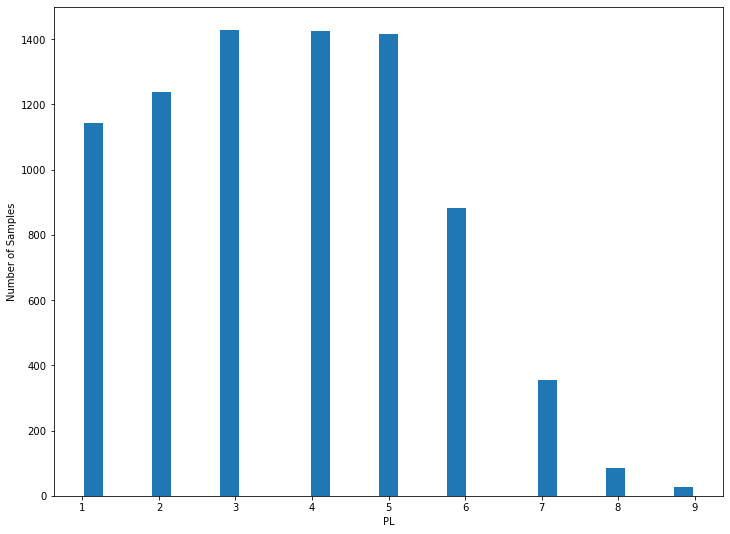

In [316]:
# Important: rooster 6_10 test split PL distribution!
fig3, ax3 = plt.subplots(figsize=(12,9))
ax3.hist(X, bins='auto', rwidth=0.85)
ax3.set_xlabel("PL")
ax3.set_ylabel("Number of Samples")

#fig3.savefig(join('images', 'ours_rooster', 'RO_test4k_hist'))
plt.show()

In [280]:
### Compute MSE, MDE, Accuracy ###
# y_gt: ground truth list
# y_pred: prediction list
def get_metric(y_gt, y_pred):
    mse_sum = 0
    mde_sum = 0
    acc_sum = 0
    
    if len(y_pred) == 0:
        return None, None, None

    for idx, gt in enumerate(y_gt):
        if isinstance(y_pred[idx], list):
            pred_val = np.mean(y_pred[idx])
            
            acc_sum += sum([item==gt for item in y_pred[idx]]) / len(y_pred[idx])
        else:
            pred_val = y_pred[idx]
            if gt == pred_val:
                acc_sum += 1
        mse_sum += abs(gt - pred_val)**2
        mde_sum += abs(gt - pred_val)
        
    
    MSE = mse_sum / len(y_gt)
    MDE = mde_sum / len(y_gt)
    Accuracy = acc_sum / len(y_gt)

    print("MSE = %.3f; MDE = %.3f; Accuracy = %.2f%%" % (MSE, MDE, Accuracy*100))
    
    return MSE, MDE, Accuracy

In [324]:
PL_metric = {}
max_PL = 10

# Compute Metrics bin by bin, e.g., PL = 1 to 10 here
for i in range(1, max_PL + 1, 1):
    gt, pred = [], []
    pred_lib, pred_aub = [], []
    pred_merge, pred_os, pred_rc, pred_cr, pred_dn, pred_se, pred_best = [], [], [], [], [], [], []
    
    for idx, val in enumerate(X):
        if val == i:
            gt.append(Y_gt[idx])
            pred.append(Y_pred[idx]) if len(Y_pred) != 0 else None
            pred_lib.append(Y_lib[idx]) if len(Y_lib) != 0 else None
            pred_aub.append(Y_aub[idx]) if len(Y_aub) != 0 else None
            pred_merge.append(Y_merge[idx]) if len(Y_merge) != 0 else None
            pred_os.append(Y_os[idx]) if len(Y_os) != 0 else None
            pred_rc.append(Y_rc[idx]) if len(Y_rc) != 0 else None
            pred_cr.append(Y_cr[idx]) if len(Y_cr) != 0 else None
            pred_dn.append(Y_dn[idx]) if len(Y_dn) != 0 else None
            pred_se.append(Y_se[idx]) if len(Y_se) != 0 else None
            pred_best.append(Y_best[idx]) if len(Y_best) != 0 else None
    
    if len(gt) >= hist_thres:
        mse, mde, accu = get_metric(gt, pred)
        mse_lib, mde_lib, accu_lib = get_metric(gt, pred_lib)
        mse_aub, mde_aub, accu_aub = get_metric(gt, pred_aub)
        mse_merge, mde_merge, accu_merge = get_metric(gt, pred_merge)
        mse_os, mde_os, accu_os = get_metric(gt, pred_os)
        mse_rc, mde_rc, accu_rc = get_metric(gt, pred_rc)
        mse_cr, mde_cr, accu_cr = get_metric(gt, pred_cr)
        mse_dn, mde_dn, accu_dn = get_metric(gt, pred_dn)
        mse_se, mde_se, accu_se = get_metric(gt, pred_se)
        mse_best, mde_best, accu_best = get_metric(gt, pred_best)
    
        PL_metric[i] = ([mse, mse_lib, mse_aub, mse_merge, mse_os, mse_rc, mse_cr, mse_dn, mse_se, mse_best], 
                        [mde, mde_lib, mde_aub, mde_merge, mde_os, mde_rc, mde_cr, mde_dn, mde_se, mse_best], 
                        [accu, accu_lib, accu_aub, accu_merge, accu_os, accu_rc, accu_cr, accu_dn, accu_se, accu_best])
    
print(PL_metric)
PL_metric_acc = [item[2][0] for item in list(PL_metric.values())]
PL_metric_MSE = [item[0][0] for item in list(PL_metric.values())]
PL_metric_MDE = [item[1][0] for item in list(PL_metric.values())]
PL_metric_acc_lib = [item[2][1] for item in list(PL_metric.values())]
PL_metric_MSE_lib = [item[0][1] for item in list(PL_metric.values())]
PL_metric_MDE_lib = [item[1][1] for item in list(PL_metric.values())]
PL_metric_acc_aub = [item[2][2] for item in list(PL_metric.values())]
PL_metric_MSE_aub = [item[0][2] for item in list(PL_metric.values())]
PL_metric_MDE_aub = [item[1][2] for item in list(PL_metric.values())]
PL_metric_acc_merge = [item[2][3] for item in list(PL_metric.values())]
PL_metric_MSE_merge = [item[0][3] for item in list(PL_metric.values())]
PL_metric_MDE_merge = [item[1][3] for item in list(PL_metric.values())]
PL_metric_acc_os = [item[2][4] for item in list(PL_metric.values())]
PL_metric_MSE_os = [item[0][4] for item in list(PL_metric.values())]
PL_metric_MDE_os = [item[1][4] for item in list(PL_metric.values())]
PL_metric_acc_rc = [item[2][5] for item in list(PL_metric.values())]
PL_metric_MSE_rc = [item[0][5] for item in list(PL_metric.values())]
PL_metric_MDE_rc = [item[1][5] for item in list(PL_metric.values())]
PL_metric_acc_cr = [item[2][6] for item in list(PL_metric.values())]
PL_metric_MSE_cr = [item[0][6] for item in list(PL_metric.values())]
PL_metric_MDE_cr = [item[1][6] for item in list(PL_metric.values())]
PL_metric_acc_dn = [item[2][7] for item in list(PL_metric.values())]
PL_metric_MSE_dn = [item[0][7] for item in list(PL_metric.values())]
PL_metric_MDE_dn = [item[1][7] for item in list(PL_metric.values())]
PL_metric_acc_se = [item[2][8] for item in list(PL_metric.values())]
PL_metric_MSE_se = [item[0][8] for item in list(PL_metric.values())]
PL_metric_MDE_se = [item[1][8] for item in list(PL_metric.values())]
PL_metric_acc_best = [item[2][9] for item in list(PL_metric.values())]
PL_metric_MSE_best = [item[0][9] for item in list(PL_metric.values())]
PL_metric_MDE_best = [item[1][9] for item in list(PL_metric.values())]

MSE = 2.568; MDE = 1.072; Accuracy = 42.31%
MSE = 9.159; MDE = 1.906; Accuracy = 28.50%
MSE = 6.645; MDE = 1.899; Accuracy = 26.84%
MSE = 2.568; MDE = 1.072; Accuracy = 42.31%
MSE = 2.568; MDE = 1.072; Accuracy = 42.31%
MSE = 2.568; MDE = 1.072; Accuracy = 42.31%
MSE = 2.568; MDE = 1.072; Accuracy = 42.31%
MSE = 2.568; MDE = 1.072; Accuracy = 42.31%
MSE = 2.568; MDE = 1.072; Accuracy = 42.31%
MSE = 2.568; MDE = 1.072; Accuracy = 42.31%
MSE = 1.699; MDE = 0.783; Accuracy = 54.32%
MSE = 7.835; MDE = 1.929; Accuracy = 16.25%
MSE = 9.789; MDE = 2.437; Accuracy = 12.77%
MSE = 1.699; MDE = 0.783; Accuracy = 54.32%
MSE = 1.699; MDE = 0.783; Accuracy = 54.32%
MSE = 1.699; MDE = 0.783; Accuracy = 54.32%
MSE = 1.699; MDE = 0.783; Accuracy = 54.32%
MSE = 1.699; MDE = 0.783; Accuracy = 54.32%
MSE = 1.699; MDE = 0.783; Accuracy = 54.32%
MSE = 1.699; MDE = 0.783; Accuracy = 54.32%
MSE = 2.176; MDE = 0.947; Accuracy = 45.38%
MSE = 10.905; MDE = 2.804; Accuracy = 6.30%
MSE = 10.569; MDE = 2.549; Accur

### Overall performance

In [94]:
# Calculate table-based Overall Accu, MSE, MAE at PL=6, 7, 8
# method seq: lib, aub, cr, dn, os
all_mse = np.zeros(5)
all_mae = np.zeros(5)
all_acc = np.zeros((5, 3))

for i in range(6, 9, 1):
    for idx, method_idx in enumerate([1, 2, 6, 7, 4]):
        
        all_acc[idx, i-6] = PL_metric[i][2][method_idx]
        
        all_mse[idx] += PL_metric[i][0][method_idx]
        all_mae[idx] += PL_metric[i][1][method_idx]
        
mse678 = all_mse / 3
mae678 = all_mae / 3
print("MSE of lib, aub, cr, dn, os: ", mse678)
print("MAE of lib, aub, cr, dn, os: ", mae678)
print("Accu. of lib, aub, cr, dn, os @ PL = 6, 7, 8: \n", all_acc)

MSE of lib, aub, cr, dn, os:  [48.28510693 14.41660757  1.46298674  1.13753933  0.65143378]
MAE of lib, aub, cr, dn, os:  [6.64978495 3.07580288 0.88231697 0.81834885 0.31586485]
Accu. of lib, aub, cr, dn, os @ PL = 6, 7, 8: 
 [[0.01021566 0.01123596 0.02325581]
 [0.11804767 0.12078652 0.06976744]
 [0.49375709 0.39044944 0.20930233]
 [0.42224745 0.32865169 0.25581395]
 [0.85925085 0.81460674 0.80232558]]


#### (Run below section only if you want to analyze based on high/low SNR instead)

In [115]:
snr_thred = -26.5  # -26.5 to differ clean/noisy; -9999 to not separate

In [83]:
# Eval performance based on SNR
PL_metric = {}
max_PL = 10

for i in range(1, max_PL + 1, 1):
    gt, pred = [], []
    gt_noisy, pred_noisy = [], []
    for idx, val in enumerate(X):
        if val == i:
            if SNR[idx] > snr_thred:
                gt.append(Y_gt[idx])
                pred.append(Y_pred[idx])
            else:
                gt_noisy.append(Y_gt[idx])
                pred_noisy.append(Y_pred[idx])
    
    if len(gt) >= hist_thres:
        mse, mde, accu = get_metric(gt, pred)
    elif len(gt)==0:
        mse, mde, accu = None, None, None
    if len(gt_noisy) >= hist_thres:
        mse_noisy, mde_noisy, accu_noisy = get_metric(gt_noisy, pred_noisy)
    elif len(gt_noisy)==0:
        mse_noisy, mde_noisy, accu_noisy = None, None, None
    PL_metric[i] = ([mse, mse_noisy], [mde, mde_noisy], [accu, accu_noisy])
    
print(PL_metric)
PL_metric_acc = [item[2][0] for item in list(PL_metric.values())]
PL_metric_MSE = [item[0][0] for item in list(PL_metric.values())]
PL_metric_MDE = [item[1][0] for item in list(PL_metric.values())]
PL_metric_acc_noisy = [item[2][1] for item in list(PL_metric.values())]
PL_metric_MSE_noisy = [item[0][1] for item in list(PL_metric.values())]
PL_metric_MDE_noisy = [item[1][1] for item in list(PL_metric.values())]

MSE = 0.010; MDE = 0.010; Accuracy = 98.96%
MSE = 0.099; MDE = 0.089; Accuracy = 91.38%
MSE = 1.349; MDE = 0.600; Accuracy = 64.76%
MSE = 2.426; MDE = 1.125; Accuracy = 35.05%
MSE = 2.286; MDE = 1.173; Accuracy = 26.32%
MSE = 2.317; MDE = 1.198; Accuracy = 24.43%
MSE = 2.630; MDE = 1.288; Accuracy = 22.86%
MSE = 3.061; MDE = 1.485; Accuracy = 11.36%
MSE = 4.885; MDE = 1.962; Accuracy = 11.54%
{1: ([0.01043115438108484, None], [0.01043115438108484, None], [0.9895688456189151, None]), 2: ([0.09913793103448276, None], [0.08928571428571429, None], [0.9137931034482759, None]), 3: ([1.3494335122242098, None], [0.6004770423375074, None], [0.6475849731663685, None]), 4: ([2.426495248742314, None], [1.1252096143096701, None], [0.3504751257685858, None]), 5: ([2.2857142857142856, None], [1.172811059907834, None], [0.2632488479262673, None]), 6: ([2.316742081447964, None], [1.1981900452488687, None], [0.24434389140271492, None]), 7: ([2.6303418803418803, None], [1.2884615384615385, None], [0.2286

#### (end)

### Plots
#### 1. Rooster-only

In [131]:
tfont = 18

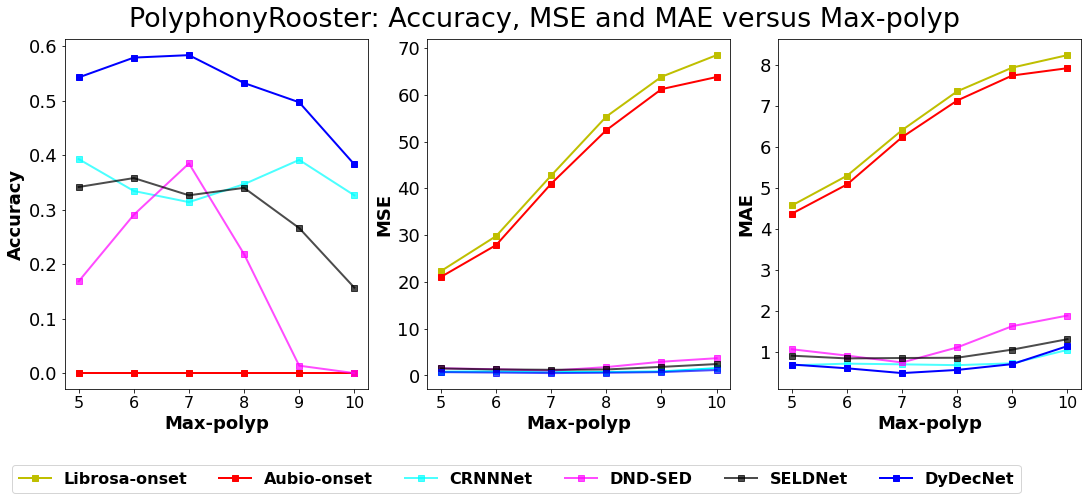

In [284]:
fig, ax = plt.subplots(1, 3, figsize=(15, 6), constrained_layout=True)
width = 0.3
start_bin = 1
x_lst = list(PL_metric)[start_bin:]

### Bar Chart ###
'''
x1 = [x - width*1.0 for x in x_lst]
ax[0].bar(x1, PL_metric_acc, color='b', 
          linewidth=2, width=width,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      )
ax[0].bar(x_lst, PL_metric_acc_lib, color='y', 
          linewidth=2, width=width,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      )
x2 = [x + width*1.0 for x in x_lst]
ax[0].bar(x2, PL_metric_acc_aub, color='r', 
          linewidth=2, width=width,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      )
ax[0].set_xlabel("Polyphony Level", fontsize=16)
ax[0].set_ylabel("Accuracy", fontsize=16)
ax[0].tick_params(axis="x", labelsize=14) 
ax[0].tick_params(axis="y", labelsize=14) 
'''

ax[0].plot(x_lst, PL_metric_acc_lib[start_bin:], color='y', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Librosa-onset')
ax[0].plot(x_lst, PL_metric_acc_aub[start_bin:], color='r', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Aubio-onset')
ax[0].plot(x_lst, PL_metric_acc_cr[start_bin:], color='cyan', linewidth=2, marker='s', alpha=0.7,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='CRNNNet')
ax[0].plot(x_lst, PL_metric_acc_dn[start_bin:], color='magenta', linewidth=2, marker='s', alpha=0.7,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='DND-SED')
ax[0].plot(x_lst, PL_metric_acc_se[start_bin:], color='k', linewidth=2, marker='s', alpha=0.7,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='SELDNet')
ax[0].plot(x_lst, PL_metric_acc_best[start_bin:], color='b', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='DyDecNet')

ax[0].set_xlabel("Max-polyp", fontsize=tfont, weight='bold')
ax[0].set_ylabel("Accuracy", fontsize=tfont, weight='bold')
ax[0].set_ylim()
ax[0].tick_params(axis="x", labelsize=tfont) 
ax[0].tick_params(axis="y", labelsize=tfont) 

ax[1].plot(x_lst, PL_metric_MSE_lib[start_bin:], color='y', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Librosa-onset')
ax[1].plot(x_lst, PL_metric_MSE_aub[start_bin:], color='r', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Aubio-onset')
ax[1].plot(x_lst, PL_metric_MSE_cr[start_bin:], color='cyan', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='CRNNNet')
ax[1].plot(x_lst, PL_metric_MSE_dn[start_bin:], color='magenta', linewidth=2, marker='s', alpha=0.7,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='DND-SED')
ax[1].plot(x_lst, PL_metric_MSE_se[start_bin:], color='k', linewidth=2, marker='s', alpha=0.7,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='SELDNet')
ax[1].plot(x_lst, PL_metric_MSE_best[start_bin:], color='b', linewidth=2, marker='s', alpha=0.7,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='DyDecNet')

ax[1].set_xlabel("Max-polyp", fontsize=tfont, weight='bold')
ax[1].set_ylabel("MSE", fontsize=tfont, weight='bold')
ax[1].set_ylim()
ax[1].tick_params(axis="x", labelsize=tfont) 
ax[1].tick_params(axis="y", labelsize=tfont) 

ax[2].plot(x_lst, PL_metric_MDE_lib[start_bin:], color='y', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Librosa-onset')
ax[2].plot(x_lst, PL_metric_MDE_aub[start_bin:], color='r', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Aubio-onset')
ax[2].plot(x_lst, PL_metric_MDE_cr[start_bin:], color='cyan', linewidth=2, marker='s', alpha=0.7,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='CRNNNet')
ax[2].plot(x_lst, PL_metric_MDE_dn[start_bin:], color='magenta', linewidth=2, marker='s', alpha=0.7,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='DND-SED')
ax[2].plot(x_lst, PL_metric_MDE_se[start_bin:], color='k', linewidth=2, marker='s', alpha=0.7,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='SELDNet')
ax[2].plot(x_lst, PL_metric_MDE_best[start_bin:], color='b', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='DyDecNet')

ax[2].set_xlabel("Max-polyp", fontsize=tfont, weight='bold')
ax[2].set_ylabel("MAE", fontsize=tfont, weight='bold')
ax[2].set_ylim()
ax[2].tick_params(axis="x", labelsize=tfont) 
ax[2].tick_params(axis="y", labelsize=tfont) 

fig.suptitle("PolyphonyRooster: Accuracy, MSE and MAE versus Max-polyp", fontsize=27)

# Set the ticks and ticklabels for all axes
plt.setp(ax, xticks=range(5, 10 + 1), xticklabels=range(5, 10 + 1))

# Use the pyplot interface to change just one subplot...
plt.sca(ax[0])
plt.xticks(range(5, 10 + 1), range(5, 10 + 1), color='k', fontsize=16)
plt.sca(ax[1])
plt.xticks(range(5, 10 + 1), range(5, 10 + 1), color='k', fontsize=16)
plt.sca(ax[2])
plt.xticks(range(5, 10 + 1), range(5, 10 + 1), color='k', fontsize=16)
# Common legend
lines, labels = fig.axes[-1].get_legend_handles_labels()
fig.legend(lines, labels, bbox_to_anchor=(0, -0.15), ncol=7, loc = 'lower left', prop={'size': 16, 'weight': 'bold'})

fig.savefig(join('images', 'ours_rooster', 'RO_40K_PL_epoch60'), bbox_inches='tight', facecolor='white', transparent=False)
plt.show()

#### 2. Four-birds v.s. other methods

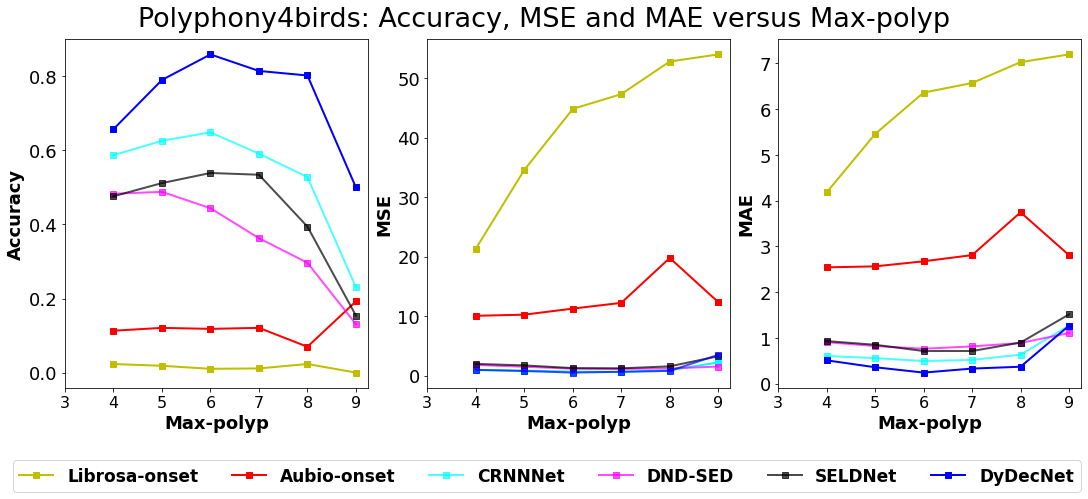

In [321]:
fig, ax = plt.subplots(1, 3, figsize=(15, 6), constrained_layout=True)
width = 0.3
start_bin = 3
x_lst = list(PL_metric)[start_bin:]

### Bar Chart ###
'''
x1 = [x - width*1.0 for x in x_lst]
ax[0].bar(x1, PL_metric_acc, color='b', 
          linewidth=2, width=width,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      )
ax[0].bar(x_lst, PL_metric_acc_lib, color='y', 
          linewidth=2, width=width,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      )
x2 = [x + width*1.0 for x in x_lst]
ax[0].bar(x2, PL_metric_acc_aub, color='r', 
          linewidth=2, width=width,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      )
ax[0].set_xlabel("Polyphony Level", fontsize=16)
ax[0].set_ylabel("Accuracy", fontsize=16)
ax[0].tick_params(axis="x", labelsize=14) 
ax[0].tick_params(axis="y", labelsize=14) 
'''

ax[0].plot(x_lst, PL_metric_acc_lib[start_bin:], color='y', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Librosa-onset')
ax[0].plot(x_lst, PL_metric_acc_aub[start_bin:], color='r', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Aubio-onset')
ax[0].plot(x_lst, PL_metric_acc_cr[start_bin:], color='cyan', linewidth=2, marker='s', alpha=0.7,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='CRNNNet')
ax[0].plot(x_lst, PL_metric_acc_dn[start_bin:], color='magenta', linewidth=2, marker='s', alpha=0.7,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='DND-SED')
ax[0].plot(x_lst, PL_metric_acc_se[start_bin:], color='k', linewidth=2, marker='s', alpha=0.7,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='SELDNet')
ax[0].plot(x_lst, PL_metric_acc_os[start_bin:], color='b', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='DyDecNet')
ax[0].set_xlabel("Max-polyp", fontsize=tfont, weight='bold')
ax[0].set_ylabel("Accuracy", fontsize=tfont, weight='bold')
ax[0].set_ylim()
ax[0].tick_params(axis="x", labelsize=tfont) 
ax[0].tick_params(axis="y", labelsize=tfont) 

ax[1].plot(x_lst, PL_metric_MSE_lib[start_bin:], color='y', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Librosa-onset')
ax[1].plot(x_lst, PL_metric_MSE_aub[start_bin:], color='r', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Aubio-onset')
ax[1].plot(x_lst, PL_metric_MSE_cr[start_bin:], color='cyan', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='CRNNNet')
ax[1].plot(x_lst, PL_metric_MSE_dn[start_bin:], color='magenta', linewidth=2, marker='s', alpha=0.7,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='DND-SED')
ax[1].plot(x_lst, PL_metric_MSE_se[start_bin:], color='k', linewidth=2, marker='s', alpha=0.7,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='SELDNet')
ax[1].plot(x_lst, PL_metric_MSE_os[start_bin:], color='b', linewidth=2, marker='s', alpha=0.7,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='DyDecNet')
ax[1].set_xlabel("Max-polyp", fontsize=tfont, weight='bold')
ax[1].set_ylabel("MSE", fontsize=tfont, weight='bold')
ax[1].set_ylim()
ax[1].tick_params(axis="x", labelsize=tfont) 
ax[1].tick_params(axis="y", labelsize=tfont) 

ax[2].plot(x_lst, PL_metric_MDE_lib[start_bin:], color='y', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Librosa-onset')
ax[2].plot(x_lst, PL_metric_MDE_aub[start_bin:], color='r', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Aubio-onset')
ax[2].plot(x_lst, PL_metric_MDE_cr[start_bin:], color='cyan', linewidth=2, marker='s', alpha=0.7,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='CRNNNet')
ax[2].plot(x_lst, PL_metric_MDE_dn[start_bin:], color='magenta', linewidth=2, marker='s', alpha=0.7,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='DND-SED')
ax[2].plot(x_lst, PL_metric_MDE_se[start_bin:], color='k', linewidth=2, marker='s', alpha=0.7,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='SELDNet')
ax[2].plot(x_lst, PL_metric_MDE_os[start_bin:], color='b', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='DyDecNet')
ax[2].set_xlabel("Max-polyp", fontsize=tfont, weight='bold')
ax[2].set_ylabel("MAE", fontsize=tfont, weight='bold')
ax[2].set_ylim()
ax[2].tick_params(axis="x", labelsize=tfont) 
ax[2].tick_params(axis="y", labelsize=tfont) 

fig.suptitle("Polyphony4birds: Accuracy, MSE and MAE versus Max-polyp", fontsize=27)

# Set the ticks and ticklabels for all axes
plt.setp(ax, xticks=range(start_bin, len(PL_metric) + 1), xticklabels=range(start_bin, len(PL_metric) + 1))

# Use the pyplot interface to change just one subplot...
plt.sca(ax[0])
plt.xticks(range(start_bin, len(PL_metric) + 1), range(start_bin, len(PL_metric) + 1), color='k', fontsize=16)
plt.sca(ax[1])
plt.xticks(range(start_bin, len(PL_metric) + 1), range(start_bin, len(PL_metric) + 1), color='k', fontsize=16)
plt.sca(ax[2])
plt.xticks(range(start_bin, len(PL_metric) + 1), range(start_bin, len(PL_metric) + 1), color='k', fontsize=16)
# Legends
'''
colors = {'Librosa':'yellow', 'Aubio':'red', 'Ours':'blue'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
ax[0].legend(handles, labels, prop={'size': 12})

ax[0].legend(loc='best', prop={'size': 12})
ax[1].legend(loc='best', prop={'size': 12})
ax[2].legend(loc='best', prop={'size': 12})
'''
# Common legend
lines, labels = fig.axes[-1].get_legend_handles_labels()
fig.legend(lines, labels, bbox_to_anchor=(0, -0.15), ncol=6, loc = 'lower left', prop={'size': 17, 'weight':'bold'})

fig.savefig(join('images', 'final_4birds', '40K_PL_epoch60'), bbox_inches='tight', facecolor='white', transparent=False)
plt.show()

#### 2.1 Ablation

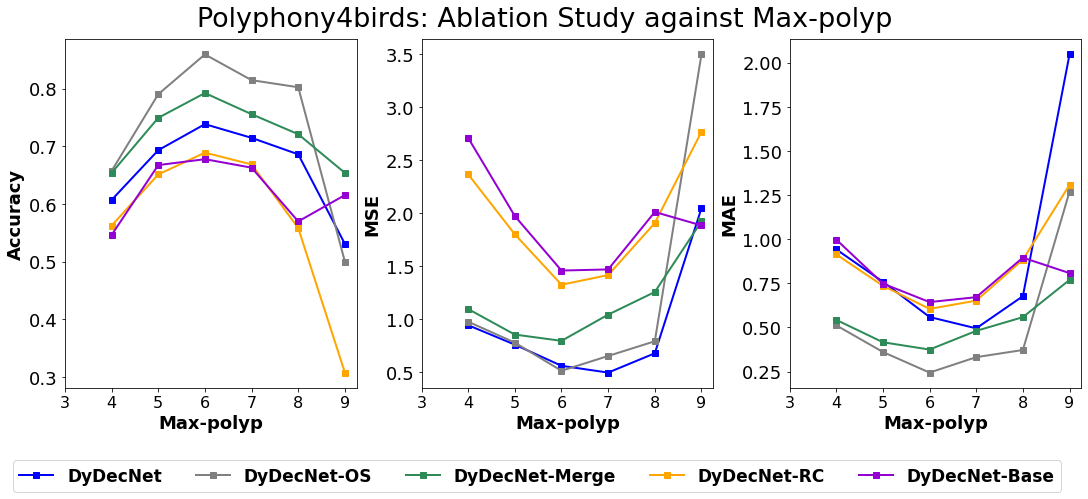

In [329]:
fig, ax = plt.subplots(1, 3, figsize=(15, 6), constrained_layout=True)
width = 0.3
start_bin = 3
x_lst = list(PL_metric)[start_bin:]

ax[0].plot(x_lst, PL_metric_acc_best[start_bin:], color='b', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='DyDecNet')
ax[0].plot(x_lst, PL_metric_acc_os[start_bin:], color='gray', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='DyDecNet-OS')
ax[0].plot(x_lst, PL_metric_acc_merge[start_bin:], color='seagreen', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='DyDecNet-Merge')
ax[0].plot(x_lst, PL_metric_acc_rc[start_bin:], color='orange', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='DyDecNet-RC')
ax[0].plot(x_lst, PL_metric_acc[start_bin:], color='darkviolet', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='DyDecNet-Base')
ax[0].set_xlabel("Max-polyp", fontsize=tfont, weight='bold')
ax[0].set_ylabel("Accuracy", fontsize=tfont, weight='bold')
ax[0].set_ylim()
ax[0].tick_params(axis="x", labelsize=tfont) 
ax[0].tick_params(axis="y", labelsize=tfont) 

ax[1].plot(x_lst, PL_metric_MSE_best[start_bin:], color='b', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='DyDecNet')
ax[1].plot(x_lst, PL_metric_MSE_os[start_bin:], color='gray', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='DyDecNet-OS')
ax[1].plot(x_lst, PL_metric_MSE_merge[start_bin:], color='seagreen', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='DyDecNet-Merge')
ax[1].plot(x_lst, PL_metric_MSE_rc[start_bin:], color='orange', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='DyDecNet-RC')
ax[1].plot(x_lst, PL_metric_MSE[start_bin:], color='darkviolet', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='DyDecNet-Base')
ax[1].set_xlabel("Max-polyp", fontsize=tfont, weight='bold')
ax[1].set_ylabel("MSE", fontsize=tfont, weight='bold')
ax[1].set_ylim()
ax[1].tick_params(axis="x", labelsize=tfont) 
ax[1].tick_params(axis="y", labelsize=tfont) 

ax[2].plot(x_lst, PL_metric_MDE_best[start_bin:], color='b', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='DyDecNet')
ax[2].plot(x_lst, PL_metric_MDE_os[start_bin:], color='gray', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='DyDecNet-OS')
ax[2].plot(x_lst, PL_metric_MDE_merge[start_bin:], color='seagreen', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='DyDecNet-Merge')
ax[2].plot(x_lst, PL_metric_MDE_rc[start_bin:], color='orange', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='DyDecNet-RC')
ax[2].plot(x_lst, PL_metric_MDE[start_bin:], color='darkviolet', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='DyDecNet-Base')
ax[2].set_xlabel("Max-polyp", fontsize=tfont, weight='bold')
ax[2].set_ylabel("MAE", fontsize=tfont, weight='bold')
ax[2].set_ylim()
ax[2].tick_params(axis="x", labelsize=tfont) 
ax[2].tick_params(axis="y", labelsize=tfont) 

fig.suptitle("Polyphony4birds: Ablation Study against Max-polyp", fontsize=27)

# Set the ticks and ticklabels for all axes
plt.setp(ax, xticks=range(start_bin,len(PL_metric) + 1), xticklabels=range(start_bin,len(PL_metric) + 1))

# Use the pyplot interface to change just one subplot...
plt.sca(ax[0])
plt.xticks(range(start_bin,len(PL_metric) + 1), range(start_bin,len(PL_metric) + 1), color='k', fontsize=16)
plt.sca(ax[1])
plt.xticks(range(start_bin,len(PL_metric) + 1), range(start_bin,len(PL_metric) + 1), color='k', fontsize=16)
plt.sca(ax[2])
plt.xticks(range(start_bin,len(PL_metric) + 1), range(start_bin,len(PL_metric) + 1), color='k', fontsize=16)
# Legends
'''
colors = {'Librosa':'yellow', 'Aubio':'red', 'Ours':'blue'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
ax[0].legend(handles, labels, prop={'size': 12})

ax[0].legend(loc='best', prop={'size': 12})
ax[1].legend(loc='best', prop={'size': 12})
ax[2].legend(loc='best', prop={'size': 12})
'''
# Common legend
lines, labels = fig.axes[-1].get_legend_handles_labels()
fig.legend(lines, labels, bbox_to_anchor=(0, -0.15), ncol=5, loc = 'lower left', prop={'size': 17,'weight':'bold'})

fig.savefig(join('images', 'final_4birds', '40K_PL_ablation'), bbox_inches='tight', facecolor='white', transparent=False)
plt.show()

#### 3. Attribute: SNR level (only if you have ran the SNR section)

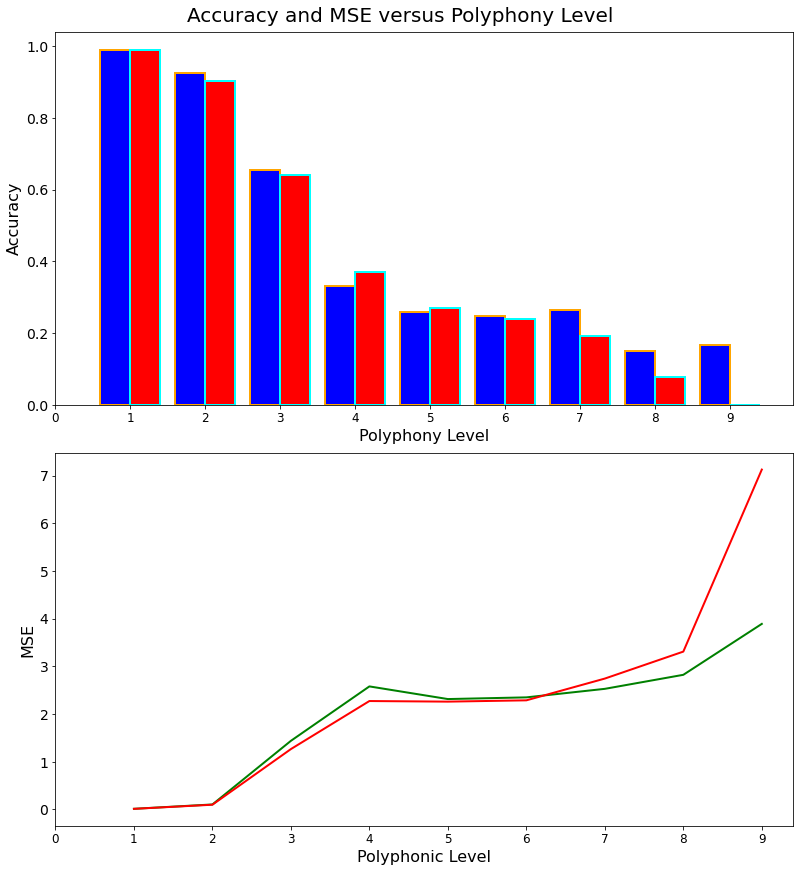

In [79]:
fig, ax = plt.subplots(2, 1, figsize=(11, 12), constrained_layout=True)
width = 0.4

x_lst = list(PL_metric)
x_lst = [x-width/2 for x in x_lst]
ax[0].bar(x_lst, PL_metric_acc, color='b', 
       edgecolor='orange', linewidth=2, width=width,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      )
x_lst2 = list(PL_metric)
x_lst2 = [x+width/2 for x in x_lst2]
ax[0].bar(x_lst2, PL_metric_acc_noisy, color='r', 
       edgecolor='cyan', linewidth=2, width=width,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      )
ax[0].set_xlabel("Polyphony Level", fontsize=16)
ax[0].set_ylabel("Accuracy", fontsize=16)
ax[0].tick_params(axis="x", labelsize=14) 
ax[0].tick_params(axis="y", labelsize=14) 

ax[1].plot(list(PL_metric), PL_metric_MSE, color='g', linewidth=2,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      )
ax[1].plot(list(PL_metric), PL_metric_MSE_noisy, color='r', linewidth=2,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      )
ax[1].set_xlabel("Polyphonic Level", fontsize=16)
ax[1].set_ylabel("MSE", fontsize=16)
ax[1].set_ylim()
ax[1].tick_params(axis="x", labelsize=14) 
ax[1].tick_params(axis="y", labelsize=14) 
'''
ax[2].plot(list(PL_metric), metric_MDE, color='g',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      )
ax[2].set_xlabel("Polyphonic Level", fontsize=16)
ax[2].set_ylabel("MDE", fontsize=16)
ax[2].set_ylim([0, 1])
'''
fig.suptitle("Accuracy and MSE versus Polyphony Level", fontsize=20)

# Set the ticks and ticklabels for all axes
plt.setp(ax, xticks=range(len(PL_metric) + 1), xticklabels=range(len(PL_metric) + 1))

# Use the pyplot interface to change just one subplot...
plt.sca(ax[0])
plt.xticks(range(len(PL_metric) + 1), range(len(PL_metric) + 1), color='k', fontsize=12)
plt.sca(ax[1])
plt.xticks(range(len(PL_metric) + 1), range(len(PL_metric) + 1), color='k', fontsize=12)

fig.savefig(join('images', '40K_PL_SNR'), bbox_inches='tight', facecolor='white', transparent=False)
plt.show()

## Polyphonic Ratio

In [330]:
sorted_result = eval_polyphony(anns, sort_attr = 'PolyphonicRatio')
X, Y_gt, Y_pred, SNR, Y_lib, Y_aub, Y_merge, Y_os, Y_rc = sorted_result[0], sorted_result[1], sorted_result[2], sorted_result[3], sorted_result[4], sorted_result[5], sorted_result[6], sorted_result[7], sorted_result[8]
Y_cr, Y_dn, Y_se, Y_best = sorted_result[9], sorted_result[10], sorted_result[11], sorted_result[12]

Number of test samples =  7998


In [331]:
PR_metric = {}
bins = 10  # Number of bins for Histogram analysis

for i in range(0, bins):
    gt, pred = [], []
    pred_lib, pred_aub = [], []
    pred_merge, pred_os, pred_rc, pred_cr, pred_dn, pred_se, pred_best = [], [], [], [], [], [], []
    
    for idx, val in enumerate(X):
        if val > i/bins and val <= i/bins + 1/bins:
            gt.append(Y_gt[idx])
            pred.append(Y_pred[idx]) if len(Y_pred) != 0 else None
            pred_lib.append(Y_lib[idx]) if len(Y_lib) != 0 else None
            pred_aub.append(Y_aub[idx]) if len(Y_aub) != 0 else None
            
            pred_merge.append(Y_merge[idx]) if len(Y_merge) != 0 else None
            pred_os.append(Y_os[idx]) if len(Y_os) != 0 else None
            pred_rc.append(Y_rc[idx]) if len(Y_rc) != 0 else None
            pred_cr.append(Y_cr[idx]) if len(Y_cr) != 0 else None
            pred_dn.append(Y_dn[idx]) if len(Y_dn) != 0 else None
            pred_se.append(Y_se[idx]) if len(Y_se) != 0 else None
            pred_best.append(Y_best[idx]) if len(Y_best) != 0 else None
    
    if len(gt) >= hist_thres:
        mse, mde, accu = get_metric(gt, pred)
        mse_lib, mde_lib, accu_lib = get_metric(gt, pred_lib)
        mse_aub, mde_aub, accu_aub = get_metric(gt, pred_aub)
        mse_merge, mde_merge, accu_merge = get_metric(gt, pred_merge)
        mse_os, mde_os, accu_os = get_metric(gt, pred_os)
        mse_rc, mde_rc, accu_rc = get_metric(gt, pred_rc)
        mse_cr, mde_cr, accu_cr = get_metric(gt, pred_cr)
        mse_dn, mde_dn, accu_dn = get_metric(gt, pred_dn)
        mse_se, mde_se, accu_se = get_metric(gt, pred_se)
        mse_best, mde_best, accu_best = get_metric(gt, pred_best)

        PR_metric[i/bins] = ([mse, mse_lib, mse_aub, mse_merge, mse_os, mse_rc, mse_cr, mse_dn, mse_se, mse_best], 
                             [mde, mde_lib, mde_aub, mde_merge, mde_os, mde_rc, mde_cr, mde_dn, mde_se, mde_best], 
                             [accu, accu_lib, accu_aub, accu_merge, accu_os, accu_rc, accu_cr, accu_dn, accu_se, accu_best])

print(PR_metric)
PR_metric_acc = [item[2][0] for item in list(PR_metric.values())]
PR_metric_MSE = [item[0][0] for item in list(PR_metric.values())]
PR_metric_MDE = [item[1][0] for item in list(PR_metric.values())]
PR_metric_acc_lib = [item[2][1] for item in list(PR_metric.values())]
PR_metric_MSE_lib = [item[0][1] for item in list(PR_metric.values())]
PR_metric_MDE_lib = [item[1][1] for item in list(PR_metric.values())]
PR_metric_acc_aub = [item[2][2] for item in list(PR_metric.values())]
PR_metric_MSE_aub = [item[0][2] for item in list(PR_metric.values())]
PR_metric_MDE_aub = [item[1][2] for item in list(PR_metric.values())]
PR_metric_acc_merge = [item[2][3] for item in list(PR_metric.values())]
PR_metric_MSE_merge = [item[0][3] for item in list(PR_metric.values())]
PR_metric_MDE_merge = [item[1][3] for item in list(PR_metric.values())]
PR_metric_acc_os = [item[2][4] for item in list(PR_metric.values())]
PR_metric_MSE_os = [item[0][4] for item in list(PR_metric.values())]
PR_metric_MDE_os = [item[1][4] for item in list(PR_metric.values())]
PR_metric_acc_rc = [item[2][5] for item in list(PR_metric.values())]
PR_metric_MSE_rc = [item[0][5] for item in list(PR_metric.values())]
PR_metric_MDE_rc = [item[1][5] for item in list(PR_metric.values())]
PR_metric_acc_cr = [item[2][6] for item in list(PR_metric.values())]
PR_metric_MSE_cr = [item[0][6] for item in list(PR_metric.values())]
PR_metric_MDE_cr = [item[1][6] for item in list(PR_metric.values())]
PR_metric_acc_dn = [item[2][7] for item in list(PR_metric.values())]
PR_metric_MSE_dn = [item[0][7] for item in list(PR_metric.values())]
PR_metric_MDE_dn = [item[1][7] for item in list(PR_metric.values())]
PR_metric_acc_se = [item[2][8] for item in list(PR_metric.values())]
PR_metric_MSE_se = [item[0][8] for item in list(PR_metric.values())]
PR_metric_MDE_se = [item[1][8] for item in list(PR_metric.values())]
PR_metric_acc_best = [item[2][9] for item in list(PR_metric.values())]
PR_metric_MSE_best = [item[0][9] for item in list(PR_metric.values())]
PR_metric_MDE_best = [item[1][9] for item in list(PR_metric.values())]

MSE = 2.347; MDE = 0.920; Accuracy = 54.46%
MSE = 11.000; MDE = 2.089; Accuracy = 16.90%
MSE = 11.653; MDE = 2.704; Accuracy = 7.51%
MSE = 2.347; MDE = 0.920; Accuracy = 54.46%
MSE = 2.347; MDE = 0.920; Accuracy = 54.46%
MSE = 2.347; MDE = 0.920; Accuracy = 54.46%
MSE = 2.347; MDE = 0.920; Accuracy = 54.46%
MSE = 2.347; MDE = 0.920; Accuracy = 54.46%
MSE = 2.347; MDE = 0.920; Accuracy = 54.46%
MSE = 2.347; MDE = 0.920; Accuracy = 54.46%
MSE = 1.569; MDE = 0.743; Accuracy = 55.84%
MSE = 7.888; MDE = 1.899; Accuracy = 14.29%
MSE = 9.842; MDE = 2.449; Accuracy = 11.95%
MSE = 1.569; MDE = 0.743; Accuracy = 55.84%
MSE = 1.569; MDE = 0.743; Accuracy = 55.84%
MSE = 1.569; MDE = 0.743; Accuracy = 55.84%
MSE = 1.569; MDE = 0.743; Accuracy = 55.84%
MSE = 1.569; MDE = 0.743; Accuracy = 55.84%
MSE = 1.569; MDE = 0.743; Accuracy = 55.84%
MSE = 1.569; MDE = 0.743; Accuracy = 55.84%
MSE = 1.433; MDE = 0.700; Accuracy = 56.88%
MSE = 8.351; MDE = 2.177; Accuracy = 13.07%
MSE = 9.552; MDE = 2.428; Accur

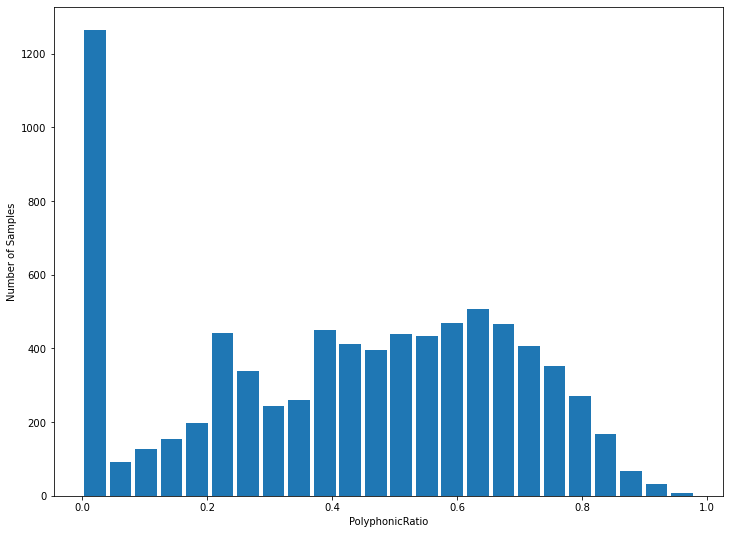

In [71]:
fig3, ax3 = plt.subplots(figsize=(12,9))
ax3.hist(X, bins='auto', rwidth=0.85)
ax3.set_xlabel("PolyphonicRatio")
ax3.set_ylabel("Number of Samples")

#fig3.savefig('ZD20K_hist')
plt.show()

#### 1. Rooster-only

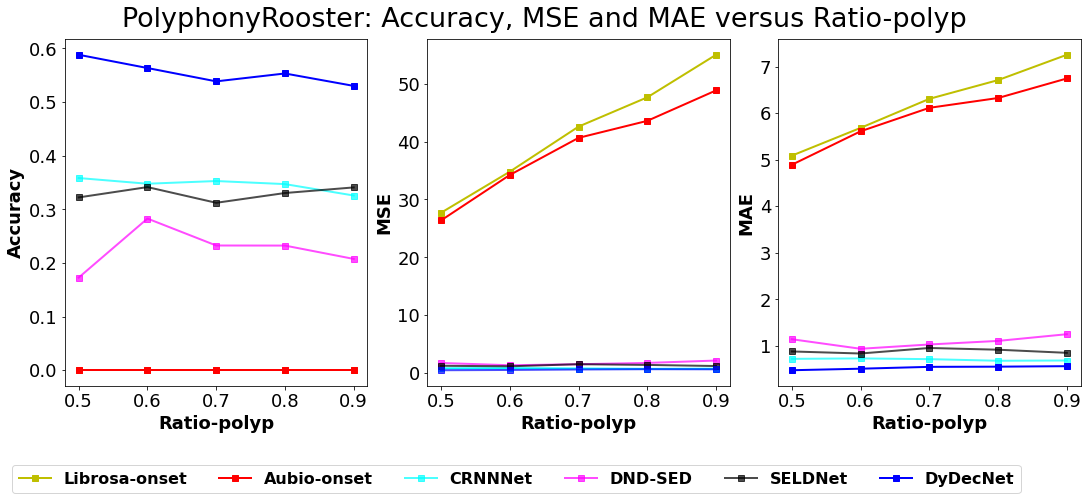

In [291]:
fig, ax = plt.subplots(1, 3, figsize=(15, 6), constrained_layout=True)
width = 0.3
start_bin = 1
x_lst = list(PR_metric)[start_bin:]

ax[0].plot(x_lst, PR_metric_acc_lib[start_bin:], color='y', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Librosa-onset')
ax[0].plot(x_lst, PR_metric_acc_aub[start_bin:], color='r', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Aubio-onset')
ax[0].plot(x_lst, PR_metric_acc_cr[start_bin:], color='cyan', linewidth=2, marker='s', alpha=0.7,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='CRNNNet')
ax[0].plot(x_lst, PR_metric_acc_dn[start_bin:], color='magenta', linewidth=2, marker='s', alpha=0.7,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='DND-SED')
ax[0].plot(x_lst, PR_metric_acc_se[start_bin:], color='k', linewidth=2, marker='s', alpha=0.7,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='SELDNet')
ax[0].plot(x_lst, PR_metric_acc_best[start_bin:], color='b', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='DyDecNet')

ax[0].set_xlabel("Ratio-polyp", fontsize=tfont, weight='bold')
ax[0].set_ylabel("Accuracy", fontsize=tfont, weight='bold')
ax[0].set_ylim()
ax[0].tick_params(axis="x", labelsize=tfont) 
ax[0].tick_params(axis="y", labelsize=tfont) 

ax[1].plot(x_lst, PR_metric_MSE_lib[start_bin:], color='y', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Librosa-onset')
ax[1].plot(x_lst, PR_metric_MSE_aub[start_bin:], color='r', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Aubio-onset')
ax[1].plot(x_lst, PR_metric_MSE_cr[start_bin:], color='cyan', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='CRNNNet')
ax[1].plot(x_lst, PR_metric_MSE_dn[start_bin:], color='magenta', linewidth=2, marker='s', alpha=0.7,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='DND-SED')
ax[1].plot(x_lst, PR_metric_MSE_se[start_bin:], color='k', linewidth=2, marker='s', alpha=0.7,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='SELDNet')
ax[1].plot(x_lst, PR_metric_MSE_best[start_bin:], color='b', linewidth=2, marker='s', alpha=0.7,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='DyDecNet')

ax[1].set_xlabel("Ratio-polyp", fontsize=tfont, weight='bold')
ax[1].set_ylabel("MSE", fontsize=tfont, weight='bold')
ax[1].set_ylim()
ax[1].tick_params(axis="x", labelsize=tfont) 
ax[1].tick_params(axis="y", labelsize=tfont) 

ax[2].plot(x_lst, PR_metric_MDE_lib[start_bin:], color='y', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Librosa-onset')
ax[2].plot(x_lst, PR_metric_MDE_aub[start_bin:], color='r', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Aubio-onset')
ax[2].plot(x_lst, PR_metric_MDE_cr[start_bin:], color='cyan', linewidth=2, marker='s', alpha=0.7,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='CRNNNet')
ax[2].plot(x_lst, PR_metric_MDE_dn[start_bin:], color='magenta', linewidth=2, marker='s', alpha=0.7,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='DND-SED')
ax[2].plot(x_lst, PR_metric_MDE_se[start_bin:], color='k', linewidth=2, marker='s', alpha=0.7,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='SELDNet')
ax[2].plot(x_lst, PR_metric_MDE_best[start_bin:], color='b', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='DyDecNet')

ax[2].set_xlabel("Ratio-polyp", fontsize=tfont, weight='bold')
ax[2].set_ylabel("MAE", fontsize=tfont, weight='bold')
ax[2].set_ylim()
ax[2].tick_params(axis="x", labelsize=tfont) 
ax[2].tick_params(axis="y", labelsize=tfont) 

fig.suptitle("PolyphonyRooster: Accuracy, MSE and MAE versus Ratio-polyp", fontsize=27)

# Common legend
lines, labels = fig.axes[-1].get_legend_handles_labels()
fig.legend(lines, labels, bbox_to_anchor=(0, -0.15), ncol=7, loc = 'lower left', prop={'size': 16, 'weight': 'bold'})

fig.savefig(join('images', 'ours_rooster', 'RO_40K_PR_epoch60'), bbox_inches='tight', facecolor='white', transparent=False)
plt.show()

#### 2. Four-bird v.s. other methods

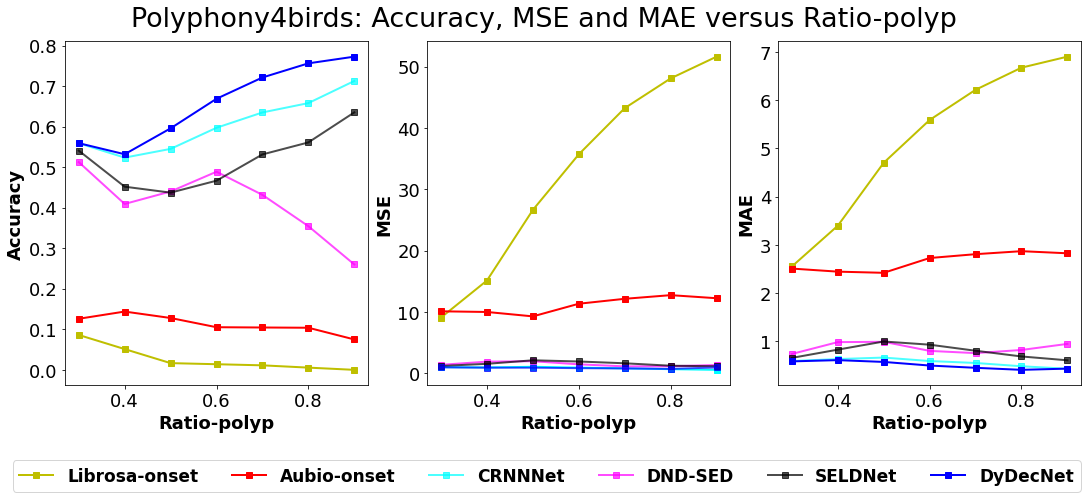

In [333]:
fig, ax = plt.subplots(1, 3, figsize=(15, 6), constrained_layout=True)
width = 0.3
start_bin = 3
x_lst = list(PR_metric)[start_bin:]

ax[0].plot(x_lst, PR_metric_acc_lib[start_bin:], color='y', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Librosa-onset')
ax[0].plot(x_lst, PR_metric_acc_aub[start_bin:], color='r', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Aubio-onset')
ax[0].plot(x_lst, PR_metric_acc_cr[start_bin:], color='cyan', linewidth=2, marker='s', alpha=0.7,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='CRNNNet')
ax[0].plot(x_lst, PR_metric_acc_dn[start_bin:], color='magenta', linewidth=2, marker='s', alpha=0.7,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='DND-SED')
ax[0].plot(x_lst, PR_metric_acc_se[start_bin:], color='k', linewidth=2, marker='s', alpha=0.7,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='SELDNet')
ax[0].plot(x_lst, PR_metric_acc_best[start_bin:], color='b', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='DyDecNet')
ax[0].set_xlabel("Ratio-polyp", fontsize=tfont, weight='bold')
ax[0].set_ylabel("Accuracy", fontsize=tfont, weight='bold')
ax[0].set_ylim()
ax[0].tick_params(axis="x", labelsize=tfont) 
ax[0].tick_params(axis="y", labelsize=tfont) 

ax[1].plot(x_lst, PR_metric_MSE_lib[start_bin:], color='y', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Librosa-onset')
ax[1].plot(x_lst, PR_metric_MSE_aub[start_bin:], color='r', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Aubio-onset')
ax[1].plot(x_lst, PR_metric_MSE_cr[start_bin:], color='cyan', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='CRNNNet')
ax[1].plot(x_lst, PR_metric_MSE_dn[start_bin:], color='magenta', linewidth=2, marker='s', alpha=0.7,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='DND-SED')
ax[1].plot(x_lst, PR_metric_MSE_se[start_bin:], color='k', linewidth=2, marker='s', alpha=0.7,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='SELDNet')
ax[1].plot(x_lst, PR_metric_MSE_best[start_bin:], color='b', linewidth=2, marker='s', alpha=0.7,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='DyDecNet')
ax[1].set_xlabel("Ratio-polyp", fontsize=tfont, weight='bold')
ax[1].set_ylabel("MSE", fontsize=tfont, weight='bold')
ax[1].set_ylim()
ax[1].tick_params(axis="x", labelsize=tfont) 
ax[1].tick_params(axis="y", labelsize=tfont) 

ax[2].plot(x_lst, PR_metric_MDE_lib[start_bin:], color='y', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Librosa-onset')
ax[2].plot(x_lst, PR_metric_MDE_aub[start_bin:], color='r', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Aubio-onset')
ax[2].plot(x_lst, PR_metric_MDE_cr[start_bin:], color='cyan', linewidth=2, marker='s', alpha=0.7,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='CRNNNet')
ax[2].plot(x_lst, PR_metric_MDE_dn[start_bin:], color='magenta', linewidth=2, marker='s', alpha=0.7,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='DND-SED')
ax[2].plot(x_lst, PR_metric_MDE_se[start_bin:], color='k', linewidth=2, marker='s', alpha=0.7,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='SELDNet')
ax[2].plot(x_lst, PR_metric_MDE_best[start_bin:], color='b', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='DyDecNet')
ax[2].set_xlabel("Ratio-polyp", fontsize=tfont, weight='bold')
ax[2].set_ylabel("MAE", fontsize=tfont, weight='bold')
ax[2].set_ylim()
ax[2].tick_params(axis="x", labelsize=tfont) 
ax[2].tick_params(axis="y", labelsize=tfont) 

fig.suptitle("Polyphony4birds: Accuracy, MSE and MAE versus Ratio-polyp", fontsize=27)

# Common legend
lines, labels = fig.axes[-1].get_legend_handles_labels()
fig.legend(lines, labels, bbox_to_anchor=(0, -0.15), ncol=6, loc = 'lower left', prop={'size': 17,'weight':'bold'})

fig.savefig(join('images', 'final_4birds', '40K_PR_epoch60'), bbox_inches='tight', facecolor='white', transparent=False)
plt.show()

#### 2.1 Ablation

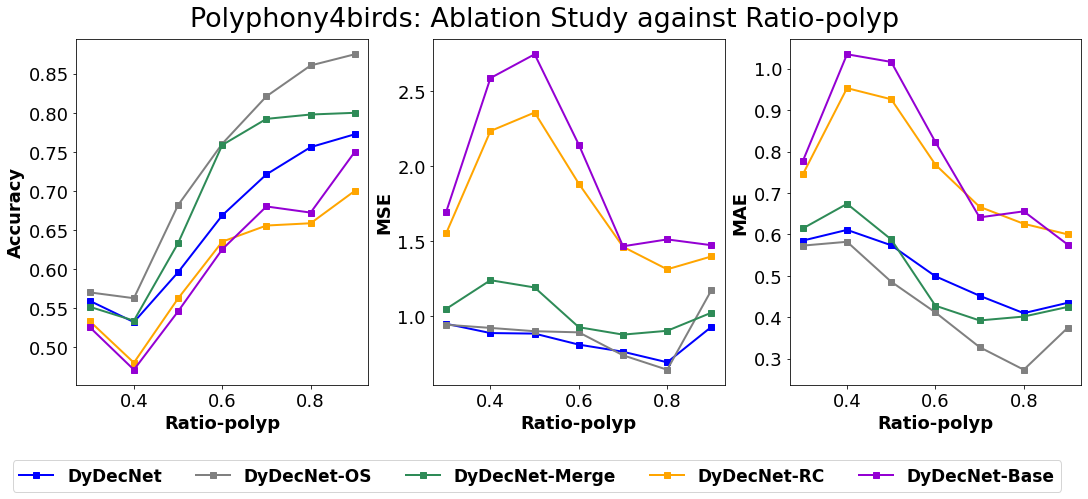

In [335]:
fig, ax = plt.subplots(1, 3, figsize=(15, 6), constrained_layout=True)
width = 0.3
start_bin = 3
x_lst = list(PR_metric)[start_bin:]

ax[0].plot(x_lst, PR_metric_acc_best[start_bin:], color='b', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='DyDecNet')
ax[0].plot(x_lst, PR_metric_acc_os[start_bin:], color='gray', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='DyDecNet-OS')
ax[0].plot(x_lst, PR_metric_acc_merge[start_bin:], color='seagreen', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='DyDecNet-Merge')
ax[0].plot(x_lst, PR_metric_acc_rc[start_bin:], color='orange', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='DyDecNet-RC')
ax[0].plot(x_lst, PR_metric_acc[start_bin:], color='darkviolet', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='DyDecNet-Base')
ax[0].set_xlabel("Ratio-polyp", fontsize=tfont, weight='bold')
ax[0].set_ylabel("Accuracy", fontsize=tfont, weight='bold')
ax[0].set_ylim()
ax[0].tick_params(axis="x", labelsize=tfont) 
ax[0].tick_params(axis="y", labelsize=tfont) 

ax[1].plot(x_lst, PR_metric_MSE_best[start_bin:], color='b', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='DyDecNet')
ax[1].plot(x_lst, PR_metric_MSE_os[start_bin:], color='gray', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='DyDecNet-OS')
ax[1].plot(x_lst, PR_metric_MSE_merge[start_bin:], color='seagreen', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='DyDecNet-Merge')
ax[1].plot(x_lst, PR_metric_MSE_rc[start_bin:], color='orange', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='DyDecNet-RC')
ax[1].plot(x_lst, PR_metric_MSE[start_bin:], color='darkviolet', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='DyDecNet-Base')
ax[1].set_xlabel("Ratio-polyp", fontsize=tfont, weight='bold')
ax[1].set_ylabel("MSE", fontsize=tfont, weight='bold')
ax[1].set_ylim()
ax[1].tick_params(axis="x", labelsize=tfont) 
ax[1].tick_params(axis="y", labelsize=tfont) 

ax[2].plot(x_lst, PR_metric_MDE_best[start_bin:], color='b', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='DyDecNet')
ax[2].plot(x_lst, PR_metric_MDE_os[start_bin:], color='gray', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='DyDecNet-OS')
ax[2].plot(x_lst, PR_metric_MDE_merge[start_bin:], color='seagreen', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='DyDecNet-Merge')
ax[2].plot(x_lst, PR_metric_MDE_rc[start_bin:], color='orange', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='DyDecNet-RC')
ax[2].plot(x_lst, PR_metric_MDE[start_bin:], color='darkviolet', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='DyDecNet-Base')
ax[2].set_xlabel("Ratio-polyp", fontsize=tfont, weight='bold')
ax[2].set_ylabel("MAE", fontsize=tfont, weight='bold')
ax[2].set_ylim()
ax[2].tick_params(axis="x", labelsize=tfont) 
ax[2].tick_params(axis="y", labelsize=tfont) 

fig.suptitle("Polyphony4birds: Ablation Study against Ratio-polyp", fontsize=27)

# Common legend
lines, labels = fig.axes[-1].get_legend_handles_labels()
fig.legend(lines, labels, bbox_to_anchor=(0, -0.15), ncol=5, loc = 'lower left', prop={'size': 17,'weight':'bold'})

fig.savefig(join('images', 'final_4birds', '40K_PR_ablation'), bbox_inches='tight', facecolor='white', transparent=False)
plt.show()

## Polyphonic Area

In [336]:
sorted_result = eval_polyphony(anns, sort_attr = 'PolyphonicArea')
X, Y_gt, Y_pred, SNR, Y_lib, Y_aub, Y_merge, Y_os, Y_rc = sorted_result[0], sorted_result[1], sorted_result[2], sorted_result[3], sorted_result[4], sorted_result[5], sorted_result[6], sorted_result[7], sorted_result[8]
Y_cr, Y_dn, Y_se, Y_best = sorted_result[9], sorted_result[10], sorted_result[11], sorted_result[12]

Number of test samples =  7998


In [337]:
areaX = np.max(X)
print("Max Area-polyp in the test set is ", areaX)

Max Area-polyp in the test set is  3.4402


In [338]:
PA_metric = {}
bins = 10  # Number of bins for Histogram analysis

for i in range(0, bins):
    gt, pred = [], []
    pred_lib, pred_aub = [], []
    pred_merge, pred_os, pred_rc, pred_cr, pred_dn, pred_se, pred_best = [], [], [], [], [], [], []
    
    for idx, val in enumerate(X):
        if val > i*areaX/bins and val <= (i/bins + 1/bins)*areaX:
            gt.append(Y_gt[idx])
            pred.append(Y_pred[idx]) if len(Y_pred) != 0 else None
            pred_lib.append(Y_lib[idx]) if len(Y_lib) != 0 else None
            pred_aub.append(Y_aub[idx]) if len(Y_aub) != 0 else None
            
            pred_merge.append(Y_merge[idx]) if len(Y_merge) != 0 else None
            pred_os.append(Y_os[idx]) if len(Y_os) != 0 else None
            pred_rc.append(Y_rc[idx]) if len(Y_rc) != 0 else None
            pred_cr.append(Y_cr[idx]) if len(Y_cr) != 0 else None
            pred_dn.append(Y_dn[idx]) if len(Y_dn) != 0 else None
            pred_se.append(Y_se[idx]) if len(Y_se) != 0 else None
            pred_best.append(Y_best[idx]) if len(Y_best) != 0 else None
    
    if len(gt) >= hist_thres:
        mse, mde, accu = get_metric(gt, pred)
        mse_lib, mde_lib, accu_lib = get_metric(gt, pred_lib)
        mse_aub, mde_aub, accu_aub = get_metric(gt, pred_aub)
        mse_merge, mde_merge, accu_merge = get_metric(gt, pred_merge)
        mse_os, mde_os, accu_os = get_metric(gt, pred_os)
        mse_rc, mde_rc, accu_rc = get_metric(gt, pred_rc)
        mse_cr, mde_cr, accu_cr = get_metric(gt, pred_cr)
        mse_dn, mde_dn, accu_dn = get_metric(gt, pred_dn)
        mse_se, mde_se, accu_se = get_metric(gt, pred_se)
        mse_best, mde_best, accu_best = get_metric(gt, pred_best)

        PA_metric[i*areaX/bins] = ([mse, mse_lib, mse_aub, mse_merge, mse_os, mse_rc, mse_cr, mse_dn, mse_se, mse_best], 
                             [mde, mde_lib, mde_aub, mde_merge, mde_os, mde_rc, mde_cr, mde_dn, mde_se, mde_best], 
                             [accu, accu_lib, accu_aub, accu_merge, accu_os, accu_rc, accu_cr, accu_dn, accu_se, accu_best])
    
print(PA_metric)
PA_metric_acc = [item[2][0] for item in list(PA_metric.values())]
PA_metric_MSE = [item[0][0] for item in list(PA_metric.values())]
PA_metric_MDE = [item[1][0] for item in list(PA_metric.values())]
PA_metric_acc_lib = [item[2][1] for item in list(PA_metric.values())]
PA_metric_MSE_lib = [item[0][1] for item in list(PA_metric.values())]
PA_metric_MDE_lib = [item[1][1] for item in list(PA_metric.values())]
PA_metric_acc_aub = [item[2][2] for item in list(PA_metric.values())]
PA_metric_MSE_aub = [item[0][2] for item in list(PA_metric.values())]
PA_metric_MDE_aub = [item[1][2] for item in list(PA_metric.values())]
PA_metric_acc_merge = [item[2][3] for item in list(PA_metric.values())]
PA_metric_MSE_merge = [item[0][3] for item in list(PA_metric.values())]
PA_metric_MDE_merge = [item[1][3] for item in list(PA_metric.values())]
PA_metric_acc_os = [item[2][4] for item in list(PA_metric.values())]
PA_metric_MSE_os = [item[0][4] for item in list(PA_metric.values())]
PA_metric_MDE_os = [item[1][4] for item in list(PA_metric.values())]
PA_metric_acc_rc = [item[2][5] for item in list(PA_metric.values())]
PA_metric_MSE_rc = [item[0][5] for item in list(PA_metric.values())]
PA_metric_MDE_rc = [item[1][5] for item in list(PA_metric.values())]
PA_metric_acc_cr = [item[2][6] for item in list(PA_metric.values())]
PA_metric_MSE_cr = [item[0][6] for item in list(PA_metric.values())]
PA_metric_MDE_cr = [item[1][6] for item in list(PA_metric.values())]
PA_metric_acc_dn = [item[2][7] for item in list(PA_metric.values())]
PA_metric_MSE_dn = [item[0][7] for item in list(PA_metric.values())]
PA_metric_MDE_dn = [item[1][7] for item in list(PA_metric.values())]
PA_metric_acc_se = [item[2][8] for item in list(PA_metric.values())]
PA_metric_MSE_se = [item[0][8] for item in list(PA_metric.values())]
PA_metric_MDE_se = [item[1][8] for item in list(PA_metric.values())]
PA_metric_acc_best = [item[2][9] for item in list(PA_metric.values())]
PA_metric_MSE_best = [item[0][9] for item in list(PA_metric.values())]
PA_metric_MDE_best = [item[1][9] for item in list(PA_metric.values())]

MSE = 1.943; MDE = 0.833; Accuracy = 55.28%
MSE = 8.980; MDE = 1.939; Accuracy = 16.26%
MSE = 10.354; MDE = 2.516; Accuracy = 10.57%
MSE = 1.943; MDE = 0.833; Accuracy = 55.28%
MSE = 1.943; MDE = 0.833; Accuracy = 55.28%
MSE = 1.943; MDE = 0.833; Accuracy = 55.28%
MSE = 1.943; MDE = 0.833; Accuracy = 55.28%
MSE = 1.943; MDE = 0.833; Accuracy = 55.28%
MSE = 1.943; MDE = 0.833; Accuracy = 55.28%
MSE = 1.943; MDE = 0.833; Accuracy = 55.28%
MSE = 1.459; MDE = 0.723; Accuracy = 54.56%
MSE = 7.970; MDE = 2.083; Accuracy = 13.18%
MSE = 9.894; MDE = 2.457; Accuracy = 12.58%
MSE = 1.459; MDE = 0.723; Accuracy = 54.56%
MSE = 1.459; MDE = 0.723; Accuracy = 54.56%
MSE = 1.459; MDE = 0.723; Accuracy = 54.56%
MSE = 1.459; MDE = 0.723; Accuracy = 54.56%
MSE = 1.459; MDE = 0.723; Accuracy = 54.56%
MSE = 1.459; MDE = 0.723; Accuracy = 54.56%
MSE = 1.459; MDE = 0.723; Accuracy = 54.56%
MSE = 1.367; MDE = 0.707; Accuracy = 52.30%
MSE = 8.375; MDE = 2.490; Accuracy = 8.85%
MSE = 10.552; MDE = 2.543; Accur

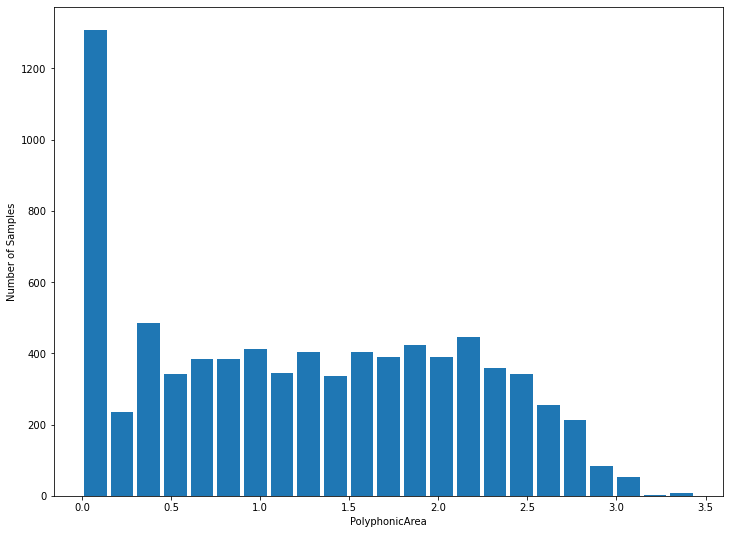

In [79]:
fig3, ax3 = plt.subplots(figsize=(12,9))
ax3.hist(X, bins='auto', rwidth=0.85)
ax3.set_xlabel("PolyphonicArea")
ax3.set_ylabel("Number of Samples")

#fig3.savefig('ZD20K_hist')
plt.show()

#### 1. Rooster-only

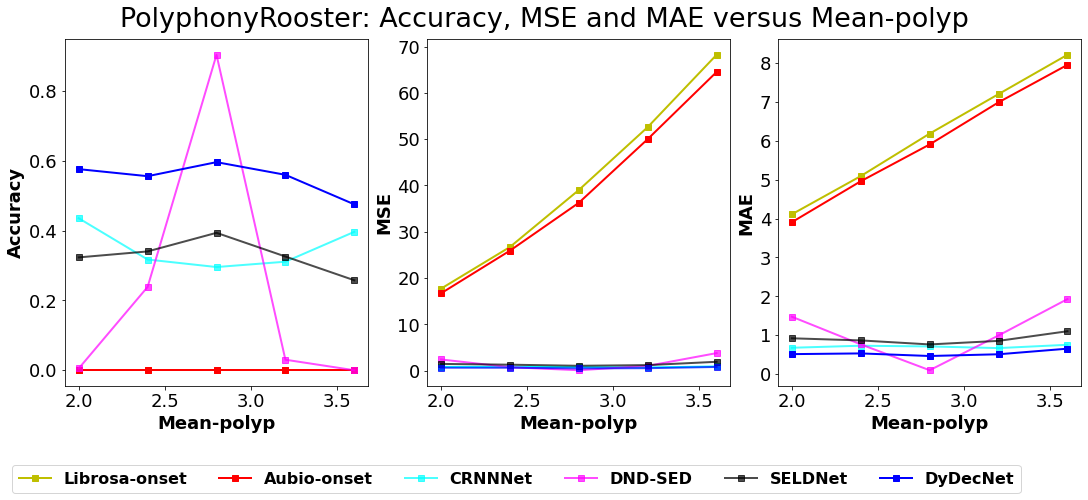

In [296]:
fig, ax = plt.subplots(1, 3, figsize=(15, 6), constrained_layout=True)
width = 0.3
start_bin = 1
x_lst = list(PA_metric)[start_bin:]

ax[0].plot(x_lst, PA_metric_acc_lib[start_bin:], color='y', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Librosa-onset')
ax[0].plot(x_lst, PA_metric_acc_aub[start_bin:], color='r', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Aubio-onset')
ax[0].plot(x_lst, PA_metric_acc_cr[start_bin:], color='cyan', linewidth=2, marker='s', alpha=0.7,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='CRNNNet')
ax[0].plot(x_lst, PA_metric_acc_dn[start_bin:], color='magenta', linewidth=2, marker='s', alpha=0.7,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='DND-SED')
ax[0].plot(x_lst, PA_metric_acc_se[start_bin:], color='k', linewidth=2, marker='s', alpha=0.7,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='SELDNet')
ax[0].plot(x_lst, PA_metric_acc_best[start_bin:], color='b', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='DyDecNet')

ax[0].set_xlabel("Mean-polyp", fontsize=tfont, weight='bold')
ax[0].set_ylabel("Accuracy", fontsize=tfont, weight='bold')
ax[0].set_ylim()
ax[0].tick_params(axis="x", labelsize=tfont) 
ax[0].tick_params(axis="y", labelsize=tfont) 

ax[1].plot(x_lst, PA_metric_MSE_lib[start_bin:], color='y', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Librosa-onset')
ax[1].plot(x_lst, PA_metric_MSE_aub[start_bin:], color='r', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Aubio-onset')
ax[1].plot(x_lst, PA_metric_MSE_cr[start_bin:], color='cyan', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='CRNNNet')
ax[1].plot(x_lst, PA_metric_MSE_dn[start_bin:], color='magenta', linewidth=2, marker='s', alpha=0.7,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='DND-SED')
ax[1].plot(x_lst, PA_metric_MSE_se[start_bin:], color='k', linewidth=2, marker='s', alpha=0.7,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='SELDNet')
ax[1].plot(x_lst, PA_metric_MSE_best[start_bin:], color='b', linewidth=2, marker='s', alpha=0.7,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='DyDecNet')

ax[1].set_xlabel("Mean-polyp", fontsize=tfont, weight='bold')
ax[1].set_ylabel("MSE", fontsize=tfont, weight='bold')
ax[1].set_ylim()
ax[1].tick_params(axis="x", labelsize=tfont) 
ax[1].tick_params(axis="y", labelsize=tfont) 

ax[2].plot(x_lst, PA_metric_MDE_lib[start_bin:], color='y', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Librosa-onset')
ax[2].plot(x_lst, PA_metric_MDE_aub[start_bin:], color='r', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Aubio-onset')
ax[2].plot(x_lst, PA_metric_MDE_cr[start_bin:], color='cyan', linewidth=2, marker='s', alpha=0.7,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='CRNNNet')
ax[2].plot(x_lst, PA_metric_MDE_dn[start_bin:], color='magenta', linewidth=2, marker='s', alpha=0.7,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='DND-SED')
ax[2].plot(x_lst, PA_metric_MDE_se[start_bin:], color='k', linewidth=2, marker='s', alpha=0.7,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='SELDNet')
ax[2].plot(x_lst, PA_metric_MDE_best[start_bin:], color='b', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='DyDecNet')

ax[2].set_xlabel("Mean-polyp", fontsize=tfont, weight='bold')
ax[2].set_ylabel("MAE", fontsize=tfont, weight='bold')
ax[2].set_ylim()
ax[2].tick_params(axis="x", labelsize=tfont) 
ax[2].tick_params(axis="y", labelsize=tfont) 

fig.suptitle("PolyphonyRooster: Accuracy, MSE and MAE versus Mean-polyp", fontsize=27)

# Common legend
lines, labels = fig.axes[-1].get_legend_handles_labels()
fig.legend(lines, labels, bbox_to_anchor=(0, -0.15), ncol=7, loc = 'lower left', prop={'size': 16, 'weight': 'bold'})

fig.savefig(join('images', 'ours_rooster', 'RO_40K_PA_epoch60'), bbox_inches='tight', facecolor='white', transparent=False)
plt.show()

#### 2. Four-bird v.s. other methods

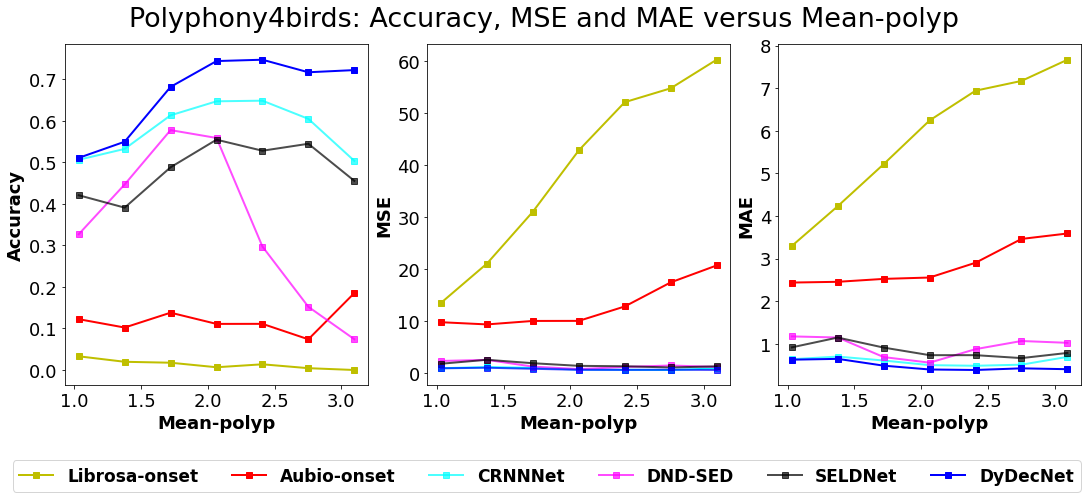

In [340]:
fig, ax = plt.subplots(1, 3, figsize=(15, 6), constrained_layout=True)
width = 0.3
start_bin = 3
x_lst = list(PA_metric)[start_bin:]

ax[0].plot(x_lst, PA_metric_acc_lib[start_bin:], color='y', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Librosa-onset')
ax[0].plot(x_lst, PA_metric_acc_aub[start_bin:], color='r', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Aubio-onset')
ax[0].plot(x_lst, PA_metric_acc_cr[start_bin:], color='cyan', linewidth=2, marker='s', alpha=0.7,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='CRNNNet')
ax[0].plot(x_lst, PA_metric_acc_dn[start_bin:], color='magenta', linewidth=2, marker='s', alpha=0.7,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='DND-SED')
ax[0].plot(x_lst, PA_metric_acc_se[start_bin:], color='k', linewidth=2, marker='s', alpha=0.7,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='SELDNet')
ax[0].plot(x_lst, PA_metric_acc_best[start_bin:], color='b', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='DyDecNet')
ax[0].set_xlabel("Mean-polyp", fontsize=tfont, weight='bold')
ax[0].set_ylabel("Accuracy", fontsize=tfont, weight='bold')
ax[0].set_ylim()
ax[0].tick_params(axis="x", labelsize=tfont) 
ax[0].tick_params(axis="y", labelsize=tfont) 

ax[1].plot(x_lst, PA_metric_MSE_lib[start_bin:], color='y', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Librosa-onset')
ax[1].plot(x_lst, PA_metric_MSE_aub[start_bin:], color='r', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Aubio-onset')
ax[1].plot(x_lst, PA_metric_MSE_cr[start_bin:], color='cyan', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='CRNNNet')
ax[1].plot(x_lst, PA_metric_MSE_dn[start_bin:], color='magenta', linewidth=2, marker='s', alpha=0.7,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='DND-SED')
ax[1].plot(x_lst, PA_metric_MSE_se[start_bin:], color='k', linewidth=2, marker='s', alpha=0.7,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='SELDNet')
ax[1].plot(x_lst, PA_metric_MSE_best[start_bin:], color='b', linewidth=2, marker='s', alpha=0.7,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='DyDecNet')
ax[1].set_xlabel("Mean-polyp", fontsize=tfont, weight='bold')
ax[1].set_ylabel("MSE", fontsize=tfont, weight='bold')
ax[1].set_ylim()
ax[1].tick_params(axis="x", labelsize=tfont) 
ax[1].tick_params(axis="y", labelsize=tfont) 

ax[2].plot(x_lst, PA_metric_MDE_lib[start_bin:], color='y', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Librosa-onset')
ax[2].plot(x_lst, PA_metric_MDE_aub[start_bin:], color='r', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Aubio-onset')
ax[2].plot(x_lst, PA_metric_MDE_cr[start_bin:], color='cyan', linewidth=2, marker='s', alpha=0.7,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='CRNNNet')
ax[2].plot(x_lst, PA_metric_MDE_dn[start_bin:], color='magenta', linewidth=2, marker='s', alpha=0.7,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='DND-SED')
ax[2].plot(x_lst, PA_metric_MDE_se[start_bin:], color='k', linewidth=2, marker='s', alpha=0.7,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='SELDNet')
ax[2].plot(x_lst, PA_metric_MDE_best[start_bin:], color='b', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='DyDecNet')
ax[2].set_xlabel("Mean-polyp", fontsize=tfont, weight='bold')
ax[2].set_ylabel("MAE", fontsize=tfont, weight='bold')
ax[2].set_ylim()
ax[2].tick_params(axis="x", labelsize=tfont) 
ax[2].tick_params(axis="y", labelsize=tfont) 

fig.suptitle("Polyphony4birds: Accuracy, MSE and MAE versus Mean-polyp", fontsize=27)

# Common legend
lines, labels = fig.axes[-1].get_legend_handles_labels()
fig.legend(lines, labels, bbox_to_anchor=(0, -0.15), ncol=6, loc = 'lower left', prop={'size': 17,'weight':'bold'})

fig.savefig(join('images', 'final_4birds', '40K_PA_epoch60'), bbox_inches='tight', facecolor='white', transparent=False)
plt.show()

#### 2.1 Ablation

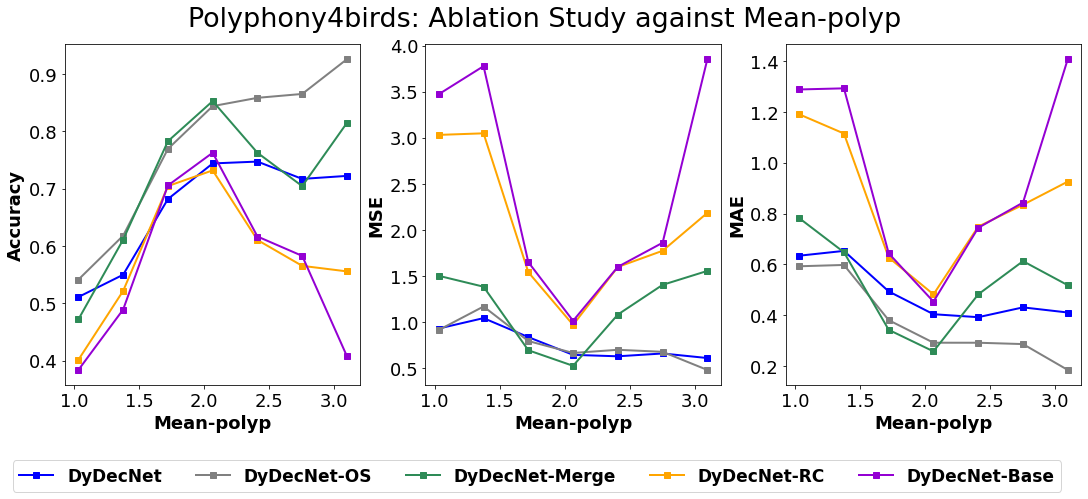

In [342]:
fig, ax = plt.subplots(1, 3, figsize=(15, 6), constrained_layout=True)
width = 0.3
start_bin = 3
x_lst = list(PA_metric)[start_bin:]

ax[0].plot(x_lst, PA_metric_acc_best[start_bin:], color='b', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='DyDecNet')
ax[0].plot(x_lst, PA_metric_acc_os[start_bin:], color='gray', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='DyDecNet-OS')
ax[0].plot(x_lst, PA_metric_acc_merge[start_bin:], color='seagreen', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='DyDecNet-Merge')
ax[0].plot(x_lst, PA_metric_acc_rc[start_bin:], color='orange', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='DyDecNet-RC')
ax[0].plot(x_lst, PA_metric_acc[start_bin:], color='darkviolet', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='DyDecNet-Base')
ax[0].set_xlabel("Mean-polyp", fontsize=tfont, weight='bold')
ax[0].set_ylabel("Accuracy", fontsize=tfont, weight='bold')
ax[0].set_ylim()
ax[0].tick_params(axis="x", labelsize=tfont) 
ax[0].tick_params(axis="y", labelsize=tfont) 

ax[1].plot(x_lst, PA_metric_MSE_best[start_bin:], color='b', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='DyDecNet')
ax[1].plot(x_lst, PA_metric_MSE_os[start_bin:], color='gray', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='DyDecNet-OS')
ax[1].plot(x_lst, PA_metric_MSE_merge[start_bin:], color='seagreen', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='DyDecNet-Merge')
ax[1].plot(x_lst, PA_metric_MSE_rc[start_bin:], color='orange', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='DyDecNet-RC')
ax[1].plot(x_lst, PA_metric_MSE[start_bin:], color='darkviolet', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='DyDecNet-Base')
ax[1].set_xlabel("Mean-polyp", fontsize=tfont, weight='bold')
ax[1].set_ylabel("MSE", fontsize=tfont, weight='bold')
ax[1].set_ylim()
ax[1].tick_params(axis="x", labelsize=tfont) 
ax[1].tick_params(axis="y", labelsize=tfont) 

ax[2].plot(x_lst, PA_metric_MDE_best[start_bin:], color='b', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='DyDecNet')
ax[2].plot(x_lst, PA_metric_MDE_os[start_bin:], color='gray', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='DyDecNet-OS')
ax[2].plot(x_lst, PA_metric_MDE_merge[start_bin:], color='seagreen', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='DyDecNet-Merge')
ax[2].plot(x_lst, PA_metric_MDE_rc[start_bin:], color='orange', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='DyDecNet-RC')
ax[2].plot(x_lst, PA_metric_MDE[start_bin:], color='darkviolet', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='DyDecNet-Base')
ax[2].set_xlabel("Mean-polyp", fontsize=tfont, weight='bold')
ax[2].set_ylabel("MAE", fontsize=tfont, weight='bold')
ax[2].set_ylim()
ax[2].tick_params(axis="x", labelsize=tfont) 
ax[2].tick_params(axis="y", labelsize=tfont) 

fig.suptitle("Polyphony4birds: Ablation Study against Mean-polyp", fontsize=27)

# Common legend
lines, labels = fig.axes[-1].get_legend_handles_labels()
fig.legend(lines, labels, bbox_to_anchor=(0, -0.15), ncol=5, loc = 'lower left', prop={'size': 17,'weight':'bold'})

fig.savefig(join('images', 'final_4birds', '40K_PA_ablation'), bbox_inches='tight', facecolor='white', transparent=False)
plt.show()

## Polyphonic Density

In [343]:
sorted_result = eval_polyphony(anns, sort_attr = 'PolyphonicDensity')
X, Y_gt, Y_pred, SNR, Y_lib, Y_aub, Y_merge, Y_os, Y_rc = sorted_result[0], sorted_result[1], sorted_result[2], sorted_result[3], sorted_result[4], sorted_result[5], sorted_result[6], sorted_result[7], sorted_result[8]
Y_cr, Y_dn, Y_se, Y_best = sorted_result[9], sorted_result[10], sorted_result[11], sorted_result[12]

Number of test samples =  7998


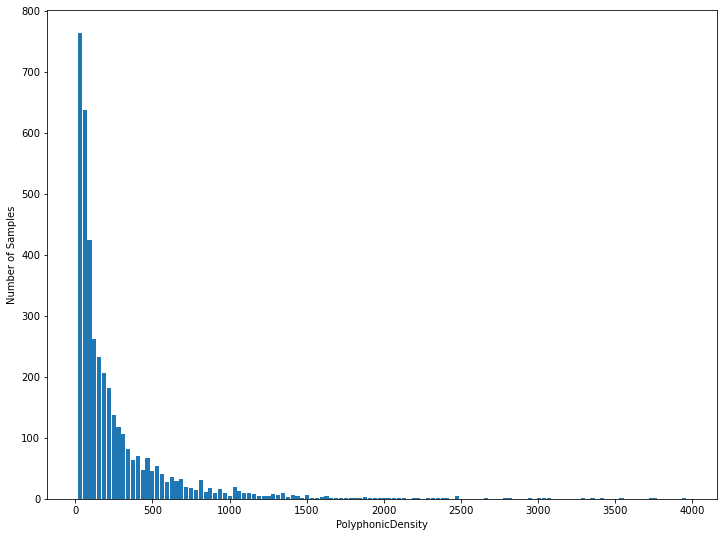

In [298]:
fig3, ax3 = plt.subplots(figsize=(12,9))
ax3.hist(X, bins='auto', rwidth=0.85)
ax3.set_xlabel("PolyphonicDensity")
ax3.set_ylabel("Number of Samples")

#fig3.savefig('ZD20K_hist')
plt.show()

#### Since PolyphonicDensity value gets exponentially large, we consider log(PD) for evaluation

In [344]:
logX = np.log(max(X))
print("Max log(PolyphonicDensity) in the test set is ", logX)

Max log(PolyphonicDensity) in the test set is  7.129495326340208


In [345]:
PD_metric = {}
bins = 10

for i in range(0, bins):
    gt, pred = [], []
    pred_lib, pred_aub = [], []
    pred_merge, pred_os, pred_rc, pred_cr, pred_dn, pred_se, pred_best = [], [], [], [], [], [], []
    
    for idx, val in enumerate(X):
        if val > 0:
            # Decide which bin based on logX / bins
            if np.log(val) > i*logX/bins and np.log(val) <= (i/bins + 1/bins)*logX:
                gt.append(Y_gt[idx])
                pred.append(Y_pred[idx]) if len(Y_pred) != 0 else None
                pred_lib.append(Y_lib[idx]) if len(Y_lib) != 0 else None
                pred_aub.append(Y_aub[idx]) if len(Y_aub) != 0 else None
                pred_merge.append(Y_merge[idx]) if len(Y_merge) != 0 else None
                pred_os.append(Y_os[idx]) if len(Y_os) != 0 else None
                pred_rc.append(Y_rc[idx]) if len(Y_rc) != 0 else None
                pred_cr.append(Y_cr[idx]) if len(Y_cr) != 0 else None
                pred_dn.append(Y_dn[idx]) if len(Y_dn) != 0 else None
                pred_se.append(Y_se[idx]) if len(Y_se) != 0 else None
                pred_best.append(Y_best[idx]) if len(Y_best) != 0 else None
    
    if len(gt) >= hist_thres:
        mse, mde, accu = get_metric(gt, pred)
        mse_lib, mde_lib, accu_lib = get_metric(gt, pred_lib)
        mse_aub, mde_aub, accu_aub = get_metric(gt, pred_aub)
        mse_merge, mde_merge, accu_merge = get_metric(gt, pred_merge)
        mse_os, mde_os, accu_os = get_metric(gt, pred_os)
        mse_rc, mde_rc, accu_rc = get_metric(gt, pred_rc)
        mse_cr, mde_cr, accu_cr = get_metric(gt, pred_cr)
        mse_dn, mde_dn, accu_dn = get_metric(gt, pred_dn)
        mse_se, mde_se, accu_se = get_metric(gt, pred_se)
        mse_best, mde_best, accu_best = get_metric(gt, pred_best)

        PD_metric[i*logX/bins] = ([mse, mse_lib, mse_aub, mse_merge, mse_os, mse_rc, mse_cr, mse_dn, mse_se, mse_best], 
                             [mde, mde_lib, mde_aub, mde_merge, mde_os, mde_rc, mde_cr, mde_dn, mde_se, mde_best], 
                             [accu, accu_lib, accu_aub, accu_merge, accu_os, accu_rc, accu_cr, accu_dn, accu_se, accu_best])

    
print(PD_metric)
PD_metric_acc = [item[2][0] for item in list(PD_metric.values())]
PD_metric_MSE = [item[0][0] for item in list(PD_metric.values())]
PD_metric_MDE = [item[1][0] for item in list(PD_metric.values())]
PD_metric_acc_lib = [item[2][1] for item in list(PD_metric.values())]
PD_metric_MSE_lib = [item[0][1] for item in list(PD_metric.values())]
PD_metric_MDE_lib = [item[1][1] for item in list(PD_metric.values())]
PD_metric_acc_aub = [item[2][2] for item in list(PD_metric.values())]
PD_metric_MSE_aub = [item[0][2] for item in list(PD_metric.values())]
PD_metric_MDE_aub = [item[1][2] for item in list(PD_metric.values())]
PD_metric_acc_merge = [item[2][3] for item in list(PD_metric.values())]
PD_metric_MSE_merge = [item[0][3] for item in list(PD_metric.values())]
PD_metric_MDE_merge = [item[1][3] for item in list(PD_metric.values())]
PD_metric_acc_os = [item[2][4] for item in list(PD_metric.values())]
PD_metric_MSE_os = [item[0][4] for item in list(PD_metric.values())]
PD_metric_MDE_os = [item[1][4] for item in list(PD_metric.values())]
PD_metric_acc_rc = [item[2][5] for item in list(PD_metric.values())]
PD_metric_MSE_rc = [item[0][5] for item in list(PD_metric.values())]
PD_metric_MDE_rc = [item[1][5] for item in list(PD_metric.values())]
PD_metric_acc_cr = [item[2][6] for item in list(PD_metric.values())]
PD_metric_MSE_cr = [item[0][6] for item in list(PD_metric.values())]
PD_metric_MDE_cr = [item[1][6] for item in list(PD_metric.values())]
PD_metric_acc_dn = [item[2][7] for item in list(PD_metric.values())]
PD_metric_MSE_dn = [item[0][7] for item in list(PD_metric.values())]
PD_metric_MDE_dn = [item[1][7] for item in list(PD_metric.values())]
PD_metric_acc_se = [item[2][8] for item in list(PD_metric.values())]
PD_metric_MSE_se = [item[0][8] for item in list(PD_metric.values())]
PD_metric_MDE_se = [item[1][8] for item in list(PD_metric.values())]
PD_metric_acc_best = [item[2][9] for item in list(PD_metric.values())]
PD_metric_MSE_best = [item[0][9] for item in list(PD_metric.values())]
PD_metric_MDE_best = [item[1][9] for item in list(PD_metric.values())]

MSE = 1.578; MDE = 0.731; Accuracy = 57.06%
MSE = 7.764; MDE = 1.886; Accuracy = 17.32%
MSE = 9.306; MDE = 2.377; Accuracy = 12.66%
MSE = 1.578; MDE = 0.731; Accuracy = 57.06%
MSE = 1.578; MDE = 0.731; Accuracy = 57.06%
MSE = 1.578; MDE = 0.731; Accuracy = 57.06%
MSE = 1.578; MDE = 0.731; Accuracy = 57.06%
MSE = 1.578; MDE = 0.731; Accuracy = 57.06%
MSE = 1.578; MDE = 0.731; Accuracy = 57.06%
MSE = 1.578; MDE = 0.731; Accuracy = 57.06%
MSE = 1.263; MDE = 0.714; Accuracy = 49.53%
MSE = 8.218; MDE = 2.373; Accuracy = 8.45%
MSE = 11.580; MDE = 2.653; Accuracy = 13.15%
MSE = 1.141; MDE = 0.678; Accuracy = 50.59%
MSE = 1.143; MDE = 0.681; Accuracy = 50.47%
MSE = 1.185; MDE = 0.695; Accuracy = 49.88%
MSE = 1.147; MDE = 0.686; Accuracy = 50.15%
MSE = 1.174; MDE = 0.699; Accuracy = 49.50%
MSE = 1.183; MDE = 0.690; Accuracy = 50.11%
MSE = 1.139; MDE = 0.683; Accuracy = 50.14%
MSE = 2.828; MDE = 1.098; Accuracy = 43.79%
MSE = 11.921; MDE = 3.042; Accuracy = 5.45%
MSE = 9.587; MDE = 2.445; Accura

#### 1. Rooster-only

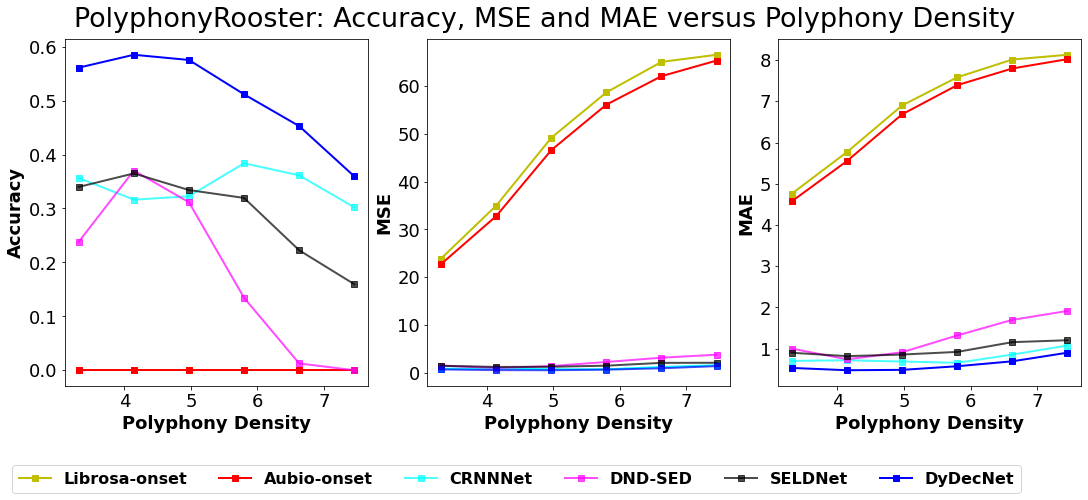

In [301]:
fig, ax = plt.subplots(1, 3, figsize=(15, 6), constrained_layout=True)
width = 0.3
start_bin = 1
x_lst = list(PD_metric)[start_bin:]

ax[0].plot(x_lst, PD_metric_acc_lib[start_bin:], color='y', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Librosa-onset')
ax[0].plot(x_lst, PD_metric_acc_aub[start_bin:], color='r', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Aubio-onset')
ax[0].plot(x_lst, PD_metric_acc_cr[start_bin:], color='cyan', linewidth=2, marker='s', alpha=0.7,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='CRNNNet')
ax[0].plot(x_lst, PD_metric_acc_dn[start_bin:], color='magenta', linewidth=2, marker='s', alpha=0.7,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='DND-SED')
ax[0].plot(x_lst, PD_metric_acc_se[start_bin:], color='k', linewidth=2, marker='s', alpha=0.7,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='SELDNet')
ax[0].plot(x_lst, PD_metric_acc_best[start_bin:], color='b', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='DyDecNet')

ax[0].set_xlabel("Polyphony Density", fontsize=tfont, weight='bold')
ax[0].set_ylabel("Accuracy", fontsize=tfont, weight='bold')
ax[0].set_ylim()
ax[0].tick_params(axis="x", labelsize=tfont) 
ax[0].tick_params(axis="y", labelsize=tfont) 

ax[1].plot(x_lst, PD_metric_MSE_lib[start_bin:], color='y', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Librosa-onset')
ax[1].plot(x_lst, PD_metric_MSE_aub[start_bin:], color='r', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Aubio-onset')
ax[1].plot(x_lst, PD_metric_MSE_cr[start_bin:], color='cyan', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='CRNNNet')
ax[1].plot(x_lst, PD_metric_MSE_dn[start_bin:], color='magenta', linewidth=2, marker='s', alpha=0.7,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='DND-SED')
ax[1].plot(x_lst, PD_metric_MSE_se[start_bin:], color='k', linewidth=2, marker='s', alpha=0.7,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='SELDNet')
ax[1].plot(x_lst, PD_metric_MSE_best[start_bin:], color='b', linewidth=2, marker='s', alpha=0.7,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='DyDecNet')

ax[1].set_xlabel("Polyphony Density", fontsize=tfont, weight='bold')
ax[1].set_ylabel("MSE", fontsize=tfont, weight='bold')
ax[1].set_ylim()
ax[1].tick_params(axis="x", labelsize=tfont) 
ax[1].tick_params(axis="y", labelsize=tfont) 

ax[2].plot(x_lst, PD_metric_MDE_lib[start_bin:], color='y', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Librosa-onset')
ax[2].plot(x_lst, PD_metric_MDE_aub[start_bin:], color='r', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Aubio-onset')
ax[2].plot(x_lst, PD_metric_MDE_cr[start_bin:], color='cyan', linewidth=2, marker='s', alpha=0.7,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='CRNNNet')
ax[2].plot(x_lst, PD_metric_MDE_dn[start_bin:], color='magenta', linewidth=2, marker='s', alpha=0.7,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='DND-SED')
ax[2].plot(x_lst, PD_metric_MDE_se[start_bin:], color='k', linewidth=2, marker='s', alpha=0.7,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='SELDNet')
ax[2].plot(x_lst, PD_metric_MDE_best[start_bin:], color='b', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='DyDecNet')

ax[2].set_xlabel("Polyphony Density", fontsize=tfont, weight='bold')
ax[2].set_ylabel("MAE", fontsize=tfont, weight='bold')
ax[2].set_ylim()
ax[2].tick_params(axis="x", labelsize=tfont) 
ax[2].tick_params(axis="y", labelsize=tfont) 

fig.suptitle("PolyphonyRooster: Accuracy, MSE and MAE versus Polyphony Density", fontsize=27)

# Common legend
lines, labels = fig.axes[-1].get_legend_handles_labels()
fig.legend(lines, labels, bbox_to_anchor=(0, -0.15), ncol=7, loc = 'lower left', prop={'size': 16, 'weight': 'bold'})

fig.savefig(join('images', 'ours_rooster', 'RO_40K_PD_epoch60'), bbox_inches='tight', facecolor='white', transparent=False)
plt.show()

#### 2. Four-bird v.s. other methods

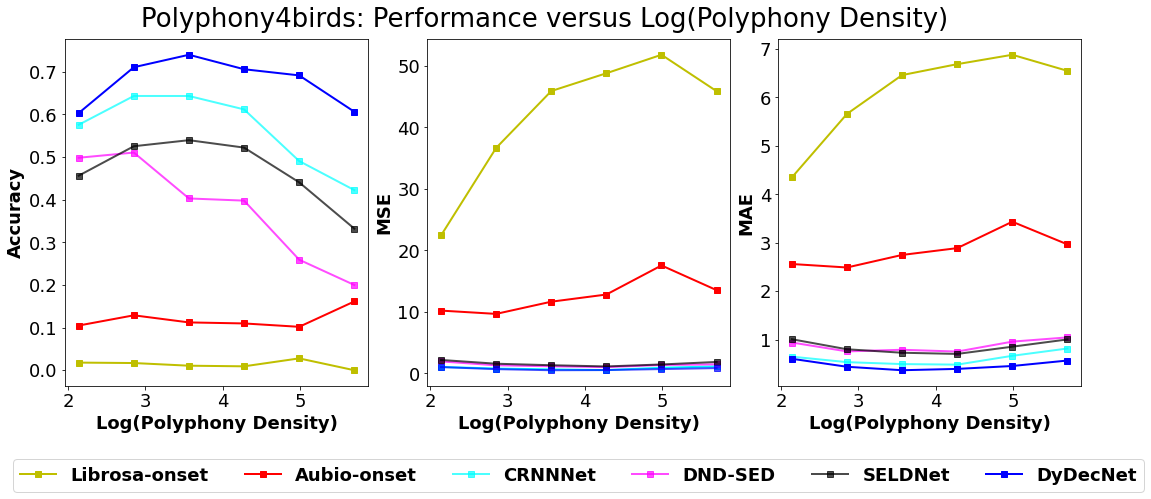

In [347]:
fig, ax = plt.subplots(1, 3, figsize=(15, 6), constrained_layout=True)
width = 0.3
start_bin = 3
x_lst = list(PD_metric)[start_bin:]

ax[0].plot(x_lst, PD_metric_acc_lib[start_bin:], color='y', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Librosa-onset')
ax[0].plot(x_lst, PD_metric_acc_aub[start_bin:], color='r', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Aubio-onset')
ax[0].plot(x_lst, PD_metric_acc_cr[start_bin:], color='cyan', linewidth=2, marker='s', alpha=0.7,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='CRNNNet')
ax[0].plot(x_lst, PD_metric_acc_dn[start_bin:], color='magenta', linewidth=2, marker='s', alpha=0.7,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='DND-SED')
ax[0].plot(x_lst, PD_metric_acc_se[start_bin:], color='k', linewidth=2, marker='s', alpha=0.7,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='SELDNet')
ax[0].plot(x_lst, PD_metric_acc_best[start_bin:], color='b', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='DyDecNet')
ax[0].set_xlabel("Log(Polyphony Density)", fontsize=tfont, weight='bold')
ax[0].set_ylabel("Accuracy", fontsize=tfont, weight='bold')
ax[0].set_ylim()
ax[0].tick_params(axis="x", labelsize=tfont) 
ax[0].tick_params(axis="y", labelsize=tfont) 

ax[1].plot(x_lst, PD_metric_MSE_lib[start_bin:], color='y', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Librosa-onset')
ax[1].plot(x_lst, PD_metric_MSE_aub[start_bin:], color='r', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Aubio-onset')
ax[1].plot(x_lst, PD_metric_MSE_cr[start_bin:], color='cyan', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='CRNNNet')
ax[1].plot(x_lst, PD_metric_MSE_dn[start_bin:], color='magenta', linewidth=2, marker='s', alpha=0.7,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='DND-SED')
ax[1].plot(x_lst, PD_metric_MSE_se[start_bin:], color='k', linewidth=2, marker='s', alpha=0.7,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='SELDNet')
ax[1].plot(x_lst, PD_metric_MSE_best[start_bin:], color='b', linewidth=2, marker='s', alpha=0.7,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='DyDecNet')
ax[1].set_xlabel("Log(Polyphony Density)", fontsize=tfont, weight='bold')
ax[1].set_ylabel("MSE", fontsize=tfont, weight='bold')
ax[1].set_ylim()
ax[1].tick_params(axis="x", labelsize=tfont) 
ax[1].tick_params(axis="y", labelsize=tfont) 

ax[2].plot(x_lst, PD_metric_MDE_lib[start_bin:], color='y', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Librosa-onset')
ax[2].plot(x_lst, PD_metric_MDE_aub[start_bin:], color='r', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='Aubio-onset')
ax[2].plot(x_lst, PD_metric_MDE_cr[start_bin:], color='cyan', linewidth=2, marker='s', alpha=0.7,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='CRNNNet')
ax[2].plot(x_lst, PD_metric_MDE_dn[start_bin:], color='magenta', linewidth=2, marker='s', alpha=0.7,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='DND-SED')
ax[2].plot(x_lst, PD_metric_MDE_se[start_bin:], color='k', linewidth=2, marker='s', alpha=0.7,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='SELDNet')
ax[2].plot(x_lst, PD_metric_MDE_best[start_bin:], color='b', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='DyDecNet')
ax[2].set_xlabel("Log(Polyphony Density)", fontsize=tfont, weight='bold')
ax[2].set_ylabel("MAE", fontsize=tfont, weight='bold')
ax[2].set_ylim()
ax[2].tick_params(axis="x", labelsize=tfont) 
ax[2].tick_params(axis="y", labelsize=tfont) 

fig.suptitle("Polyphony4birds: Performance versus Log(Polyphony Density)", fontsize=26)

# Common legend
lines, labels = fig.axes[-1].get_legend_handles_labels()
fig.legend(lines, labels, bbox_to_anchor=(0, -0.15), ncol=6, loc = 'lower left', prop={'size': tfont,'weight':'bold'})

fig.savefig(join('images', 'final_4birds', '40K_PD_epoch60'), bbox_inches='tight', facecolor='white', transparent=False)
plt.show()

#### 2.1 Ablation

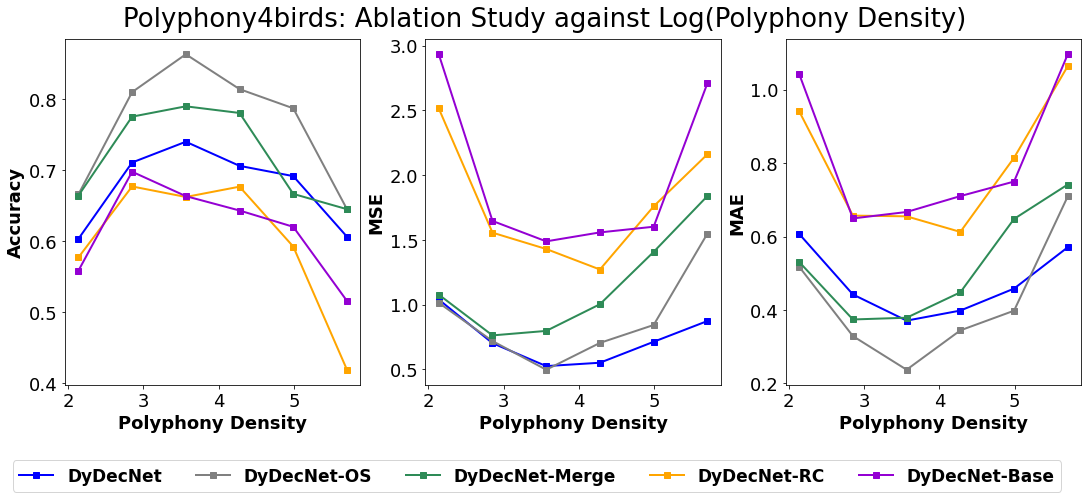

In [349]:
fig, ax = plt.subplots(1, 3, figsize=(15, 6), constrained_layout=True)
width = 0.3
start_bin = 3
x_lst = list(PD_metric)[start_bin:]

ax[0].plot(x_lst, PD_metric_acc_best[start_bin:], color='b', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='DyDecNet')
ax[0].plot(x_lst, PD_metric_acc_os[start_bin:], color='gray', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='DyDecNet-OS')
ax[0].plot(x_lst, PD_metric_acc_merge[start_bin:], color='seagreen', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='DyDecNet-Merge')
ax[0].plot(x_lst, PD_metric_acc_rc[start_bin:], color='orange', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='DyDecNet-RC')
ax[0].plot(x_lst, PD_metric_acc[start_bin:], color='darkviolet', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='DyDecNet-Base')
ax[0].set_xlabel("Polyphony Density", fontsize=tfont, weight='bold')
ax[0].set_ylabel("Accuracy", fontsize=tfont, weight='bold')
ax[0].set_ylim()
ax[0].tick_params(axis="x", labelsize=tfont) 
ax[0].tick_params(axis="y", labelsize=tfont) 

ax[1].plot(x_lst, PD_metric_MSE_best[start_bin:], color='b', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='DyDecNet')
ax[1].plot(x_lst, PD_metric_MSE_os[start_bin:], color='gray', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='DyDecNet-OS')
ax[1].plot(x_lst, PD_metric_MSE_merge[start_bin:], color='seagreen', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='DyDecNet-Merge')
ax[1].plot(x_lst, PD_metric_MSE_rc[start_bin:], color='orange', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='DyDecNet-RC')
ax[1].plot(x_lst, PD_metric_MSE[start_bin:], color='darkviolet', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='DyDecNet-Base')
ax[1].set_xlabel("Polyphony Density", fontsize=tfont, weight='bold')
ax[1].set_ylabel("MSE", fontsize=tfont, weight='bold')
ax[1].set_ylim()
ax[1].tick_params(axis="x", labelsize=tfont) 
ax[1].tick_params(axis="y", labelsize=tfont) 

ax[2].plot(x_lst, PD_metric_MDE_best[start_bin:], color='b', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='DyDecNet')
ax[2].plot(x_lst, PD_metric_MDE_os[start_bin:], color='gray', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='DyDecNet-OS')
ax[2].plot(x_lst, PD_metric_MDE_merge[start_bin:], color='seagreen', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='DyDecNet-Merge')
ax[2].plot(x_lst, PD_metric_MDE_rc[start_bin:], color='orange', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='DyDecNet-RC')
ax[2].plot(x_lst, PD_metric_MDE[start_bin:], color='darkviolet', linewidth=2, marker='s',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      label='DyDecNet-Base')
ax[2].set_xlabel("Polyphony Density", fontsize=tfont, weight='bold')
ax[2].set_ylabel("MAE", fontsize=tfont, weight='bold')
ax[2].set_ylim()
ax[2].tick_params(axis="x", labelsize=tfont) 
ax[2].tick_params(axis="y", labelsize=tfont)  

fig.suptitle("Polyphony4birds: Ablation Study against Log(Polyphony Density)", fontsize=26)

# Common legend
lines, labels = fig.axes[-1].get_legend_handles_labels()
fig.legend(lines, labels, bbox_to_anchor=(0, -0.15), ncol=5, loc = 'lower left', prop={'size': 17,'weight':'bold'})

fig.savefig(join('images', 'final_4birds', '40K_PD_ablation'), bbox_inches='tight', facecolor='white', transparent=False)
plt.show()